In [12]:
import torch

In [13]:
def rgb_to_edges(image: torch.Tensor) -> torch.Tensor:
    """Convert RGB image to edge coordinates (differentiable)"""
    # Convert to grayscale (preserves gradients)
    weights = torch.tensor([0.299, 0.587, 0.114], device=image.device)
    gray = torch.einsum('chw,c->hw', image, weights)  # For batch: 'bchw,c->bhw'
    
    # Differentiable Sobel filtering
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], device=image.device).float()
    sobel_y = sobel_x.T
    gx = torch.nn.functional.conv2d(gray[None,None,:,:], sobel_x[None,None,:,:])
    gy = torch.nn.functional.conv2d(gray[None,None,:,:], sobel_y[None,None,:,:])
    
    # Edge magnitude with safe sqrt
    edge_mag = torch.sqrt(gx**2 + gy**2 + 1e-6).squeeze()
    
    # Differentiable thresholding (soft mask)
    threshold = 0.1 * edge_mag.max()
    edge_mask = torch.sigmoid(10*(edge_mag - threshold))
    
    return edge_mask

def mask_to_points(edge_mask: torch.Tensor) -> torch.Tensor:
    """Convert edge mask to (N,2) coordinate tensor"""
    h, w = edge_mask.shape
    y_coords, x_coords = torch.meshgrid(torch.arange(h), torch.arange(w), indexing='ij')
    coords = torch.stack([x_coords.float(), y_coords.float()], dim=-1).to(edge_mask.device)
    
    # Weighted sampling (differentiable alternative to argwhere)
    weights = edge_mask.flatten()
    sample_idx = torch.multinomial(weights + 1e-6, min(1000, weights.sum().int()), replacement=True)
    
    return coords.view(-1,2)[sample_idx]

# def fit_ellipse(points: torch.Tensor) -> torch.Tensor:
#     """
#     Differentiable ellipse fitting with enhanced numerical stability.
    
#     Args:
#         points: Tensor of shape (N, 2) containing x,y coordinates of points
        
#     Returns:
#         Tensor of shape (2,) containing [major_axis, minor_axis] lengths in pixels
#     """
#     if len(points) < 5:  # Need at least 5 points to fit an ellipse
#         return torch.tensor([0.0, 0.0], device=points.device)
        
#     # Normalize to [-1, 1] range using image dimensions
#     h, w = 48, 48  # Your image dimensions
#     scale = torch.tensor([w, h], device=points.device)
#     normalized = points / scale * 2 - 1
    
#     # Build design matrix with double precision
#     x, y = normalized[:,0].double(), normalized[:,1].double()
#     D = torch.stack([x**2, x*y, y**2, x, y, torch.ones_like(x)], dim=1)
    
#     # Improved constraint matrix with better conditioning
#     C = torch.zeros(6, 6, dtype=torch.double, device=points.device)
#     C[0,2] = C[2,0] = 2
#     C[1,1] = -1
    
#     # Add regularization scaled by matrix norm
#     reg_scale = 1e-3 * torch.linalg.norm(D.T @ D)
#     C += reg_scale * torch.eye(6, dtype=torch.double, device=points.device)
    
#     # Solve generalized eigenvalue problem with better numerical stability
#     S = D.T @ D
#     try:
#         # Try Cholesky decomposition first
#         L = torch.linalg.cholesky(C)
#         L_inv = torch.linalg.inv(L)
#         M = L_inv.T @ S @ L_inv
#         eigvals, eigvecs = torch.linalg.eigh(M)  # Using eigh for symmetric matrix
#         eigvecs = L_inv @ eigvecs
#     except:
#         try:
#             # Fallback to generalized eigenvalue problem
#             eigvals, eigvecs = torch.linalg.eig(torch.linalg.solve(C, S))
#         except:
#             # Last resort: pseudoinverse
#             C_pinv = torch.linalg.pinv(C)
#             eigvals, eigvecs = torch.linalg.eig(C_pinv @ S)
    
#     # Select valid eigenvalue with improved numerical threshold
#     eps = torch.finfo(torch.double).eps
#     mask = (eigvals.real > eps) & (torch.abs(eigvals.imag) < eps)
#     valid_idx = torch.where(mask)[0]
    
#     if len(valid_idx) == 0:
#         return torch.tensor([0.0, 0.0], device=points.device)
    
#     # Select eigenvector with smallest positive eigenvalue
#     idx = valid_idx[torch.argmin(eigvals[valid_idx].real)]
#     v = eigvecs[:, idx].real
    
#     # Convert coefficients to axis lengths with robust denominator handling
#     a, b, c, d, e, f = v
#     den = b**2 - 4*a*c
    
#     if torch.abs(den) < eps:
#         return torch.tensor([0.0, 0.0], device=points.device)
    
#     # Improved formula with better numerical stability
#     num = 2 * (a*e**2 + c*d**2 - b*d*e + den*f)
#     sqrt_term = torch.sqrt((a-c)**2 + b**2)
    
#     # Handle potential negative values under sqrt
#     if num < 0:
#         return torch.tensor([0.0, 0.0], device=points.device)
    
#     try:
#         major_norm = torch.sqrt(num / (den * (-sqrt_term - a - c)))
#         minor_norm = torch.sqrt(num / (den * (sqrt_term - a - c)))
#     except:
#         return torch.tensor([0.0, 0.0], device=points.device)
    
#     # Ensure major axis is larger than minor axis
#     major = major_norm * (w / 2)
#     minor = minor_norm * (h / 2)
    
#     if major < minor:
#         major, minor = minor, major
        
#     return torch.stack([major, minor]).float()

# import torch

# def fit_ellipse(points: torch.Tensor,
#                 reg_factor: float = 1e-3,
#                 temperature: float = 1e-8) -> torch.Tensor:
#     """
#     Differentiable ellipse fitting with improved numerical stability.
    
#     Args:
#         points: Tensor of shape (N, 2) containing x,y coordinates of points.
#                 (Assumed to be in pixel coordinates.)
#         reg_factor: Regularization factor for the constraint matrix.
#         temperature: Temperature parameter used in soft selection of eigenvectors.
        
#     Returns:
#         Tensor of shape (2,) containing [major_axis, minor_axis] lengths in pixels.
#     """
#     # Need at least 5 points to reliably fit an ellipse.
#     if points.shape[0] < 5:
#         return torch.tensor([0.0, 0.0], device=points.device)
    
#     # --------------------------
#     # 1. Data-driven Normalization
#     # --------------------------
#     # Compute bounding box of the points.
#     x_min = points[:, 0].min()
#     x_max = points[:, 0].max()
#     y_min = points[:, 1].min()
#     y_max = points[:, 1].max()
    
#     # Compute center and size of bounding box.
#     center = torch.stack([(x_min + x_max) / 2, (y_min + y_max) / 2])
#     w_data = torch.clamp(x_max - x_min, min=1e-6)
#     h_data = torch.clamp(y_max - y_min, min=1e-6)
    
#     # Normalize points to the range [-1, 1] separately by dimension.
#     normalized_x = (points[:,0] - center[0]) / (w_data / 2)
#     normalized_y = (points[:,1] - center[1]) / (h_data / 2)
#     normalized = torch.stack([normalized_x, normalized_y], dim=1)
    
#     # --------------------------
#     # 2. Build the Design Matrix
#     # --------------------------
#     # Use double precision for stability.
#     x = normalized[:,0].double()
#     y = normalized[:,1].double()
#     # Each row of D corresponds to [x^2, x*y, y^2, x, y, 1].
#     D = torch.stack([x**2, x*y, y**2, x, y, torch.ones_like(x)], dim=1)
    
#     # --------------------------
#     # 3. Constraint Matrix and Regularization
#     # --------------------------
#     # Set up the constraint matrix C.
#     C = torch.zeros(6, 6, dtype=torch.double, device=points.device)
#     C[0,2] = C[2,0] = 2
#     C[1,1] = -1

#     # Regularize C to help ensure it is well-conditioned.
#     reg_value = reg_factor * torch.linalg.norm(D.T @ D)
#     C += reg_value * torch.eye(6, dtype=torch.double, device=points.device)
    
#     # --------------------------
#     # 4. Solve the Generalized Eigenvalue Problem
#     # --------------------------
#     S = D.T @ D
#     try:
#         # First try a Cholesky-based approach.
#         L = torch.linalg.cholesky(C)
#         L_inv = torch.linalg.inv(L)
#         M = L_inv.T @ S @ L_inv
#         eigvals, eigvecs = torch.linalg.eigh(M)   # eigh for symmetric M
#         eigvecs = L_inv @ eigvecs
#     except Exception as e:
#         try:
#             # Fallback to solving C^-1 S directly.
#             eigvals, eigvecs = torch.linalg.eig(torch.linalg.solve(C, S))
#         except Exception as e:
#             # Final fallback: use the pseudoinverse.
#             C_pinv = torch.linalg.pinv(C)
#             eigvals, eigvecs = torch.linalg.eig(C_pinv @ S)
    
#     # --------------------------
#     # 5. Soft Selection over Valid Eigenvectors
#     # --------------------------
#     eps = torch.finfo(torch.double).eps
#     # Consider as valid those eigenvalues that are positive and nearly real.
#     mask = (eigvals.real > eps) & (torch.abs(eigvals.imag) < eps)
#     valid_idx = torch.where(mask)[0]
    
#     if valid_idx.numel() == 0:
#         return torch.tensor([0.0, 0.0], device=points.device)
    
#     valid_eigvals = eigvals[valid_idx].real
#     # Use a softmax (over the negatives, so that smaller eigenvalues dominate)
#     weights = torch.softmax(-valid_eigvals / temperature, dim=0)
#     # Form a weighted combination of eigenvectors (soft selection)
#     selected_v = (eigvecs[:, valid_idx].real * weights).sum(dim=1)
#     v = selected_v  # This is our combined coefficient vector.
    
#     # --------------------------
#     # 6. Compute Ellipse Axes
#     # --------------------------
#     a, b, c, d, e, f = v
#     den = b**2 - 4*a*c
#     if torch.abs(den) < eps:
#         return torch.tensor([0.0, 0.0], device=points.device)
    
#     # Compute the numerator as in the standard derivation.
#     num = 2 * (a*e**2 + c*d**2 - b*d*e + den*f)
#     sqrt_term = torch.sqrt((a-c)**2 + b**2)
#     if num < 0:
#         return torch.tensor([0.0, 0.0], device=points.device)
    
#     try:
#         major_norm = torch.sqrt(num / (den * (-sqrt_term - a - c)))
#         minor_norm = torch.sqrt(num / (den * (sqrt_term - a - c)))
#     except Exception as ex:
#         return torch.tensor([0.0, 0.0], device=points.device)
    
#     # --------------------------
#     # 7. Denormalize to Pixel Units
#     # --------------------------
#     # In the normalized space, x was scaled by (w_data/2) and y by (h_data/2).
#     # For an approximate conversion back to pixels we use the average half-size.
#     scale_factor = (w_data + h_data) / 4.0
#     major_pix = major_norm * scale_factor
#     minor_pix = minor_norm * scale_factor
    
#     # Use differentiable max and min to ensure major_pix >= minor_pix.
#     major_final = torch.maximum(major_pix, minor_pix)
#     minor_final = torch.minimum(major_pix, minor_pix)
    
#     return torch.stack([major_final, minor_final]).float()

import torch

def fit_ellipse(points: torch.Tensor,
                reg_factor: float = 1e-3,
                temperature: float = 1e-8) -> torch.Tensor:
    """
    Differentiable ellipse fitting with improved numerical stability.
    
    Args:
        points: Tensor of shape (N, 2) containing x,y coordinates of points.
                (Assumed to be in pixel coordinates.)
        reg_factor: Regularization factor for the constraint matrix.
        temperature: Temperature parameter used in soft selection of eigenvectors.
        
    Returns:
        Tensor of shape (2,) containing [major_axis, minor_axis] lengths in pixels.
    """
    # Need at least 5 points to reliably fit an ellipse.
    if points.shape[0] < 5:
        return torch.tensor([0.0, 0.0], device=points.device)
    
    # --------------------------
    # 1. Isotropic Normalization
    # --------------------------
    # Compute bounding box of the points
    x_min, x_max = points[:, 0].min(), points[:, 0].max()
    y_min, y_max = points[:, 1].min(), points[:, 1].max()
    
    # Compute center and maximum extent
    center = torch.stack([(x_min + x_max) / 2, (y_min + y_max) / 2])
    extent = torch.max(torch.stack([
        torch.clamp(x_max - x_min, min=1e-6),
        torch.clamp(y_max - y_min, min=1e-6)
    ]))
    
    # Normalize points to [-1, 1] using the same scale for both dimensions
    normalized = 2 * (points - center.unsqueeze(0)) / extent
    
    # --------------------------
    # 2. Build the Design Matrix
    # --------------------------
    x = normalized[:,0].double()
    y = normalized[:,1].double()
    D = torch.stack([x**2, x*y, y**2, x, y, torch.ones_like(x)], dim=1)
    
    # --------------------------
    # 3. Constraint Matrix and Regularization
    # --------------------------
    C = torch.zeros(6, 6, dtype=torch.double, device=points.device)
    C[0,2] = C[2,0] = 2
    C[1,1] = -1
    
    reg_value = reg_factor * torch.linalg.norm(D.T @ D)
    C += reg_value * torch.eye(6, dtype=torch.double, device=points.device)
    
    # --------------------------
    # 4. Solve the Generalized Eigenvalue Problem
    # --------------------------
    S = D.T @ D
    try:
        L = torch.linalg.cholesky(C)
        L_inv = torch.linalg.inv(L)
        M = L_inv.T @ S @ L_inv
        eigvals, eigvecs = torch.linalg.eigh(M)
        eigvecs = L_inv @ eigvecs
    except Exception as e:
        try:
            eigvals, eigvecs = torch.linalg.eig(torch.linalg.solve(C, S))
        except Exception as e:
            C_pinv = torch.linalg.pinv(C)
            eigvals, eigvecs = torch.linalg.eig(C_pinv @ S)
    
    # --------------------------
    # 5. Soft Selection over Valid Eigenvectors
    # --------------------------
    eps = torch.finfo(torch.double).eps
    mask = (eigvals.real > eps) & (torch.abs(eigvals.imag) < eps)
    valid_idx = torch.where(mask)[0]
    
    if valid_idx.numel() == 0:
        return torch.tensor([0.0, 0.0], device=points.device)
    
    valid_eigvals = eigvals[valid_idx].real
    weights = torch.softmax(-valid_eigvals / temperature, dim=0)
    selected_v = (eigvecs[:, valid_idx].real * weights).sum(dim=1)
    v = selected_v
    
    # --------------------------
    # 6. Compute Ellipse Axes
    # --------------------------
    a, b, c, d, e, f = v
    den = b**2 - 4*a*c
    if torch.abs(den) < eps:
        return torch.tensor([0.0, 0.0], device=points.device)
    
    num = 2 * (a*e**2 + c*d**2 - b*d*e + den*f)
    sqrt_term = torch.sqrt((a-c)**2 + b**2)
    if num < 0:
        return torch.tensor([0.0, 0.0], device=points.device)
    
    try:
        major_norm = torch.sqrt(num / (den * (-sqrt_term - a - c)))
        minor_norm = torch.sqrt(num / (den * (sqrt_term - a - c)))
    except Exception as ex:
        return torch.tensor([0.0, 0.0], device=points.device)
    
    # --------------------------
    # 7. Denormalize to Pixel Units
    # --------------------------
    # Convert back to pixel units using the same scale factor
    major_pix = major_norm * (extent / 2)
    minor_pix = minor_norm * (extent / 2)
    
    # Ensure major axis is larger while maintaining differentiability
    major_final = torch.maximum(major_pix, minor_pix)
    minor_final = torch.minimum(major_pix, minor_pix)
    
    return torch.stack([major_final, minor_final]).float()

def image_to_ellipse(image: torch.Tensor) -> torch.Tensor:
    # Input: (3, H, W) RGB image tensor
    edge_mask = rgb_to_edges(image)
    points = mask_to_points(edge_mask)
    return fit_ellipse(points)


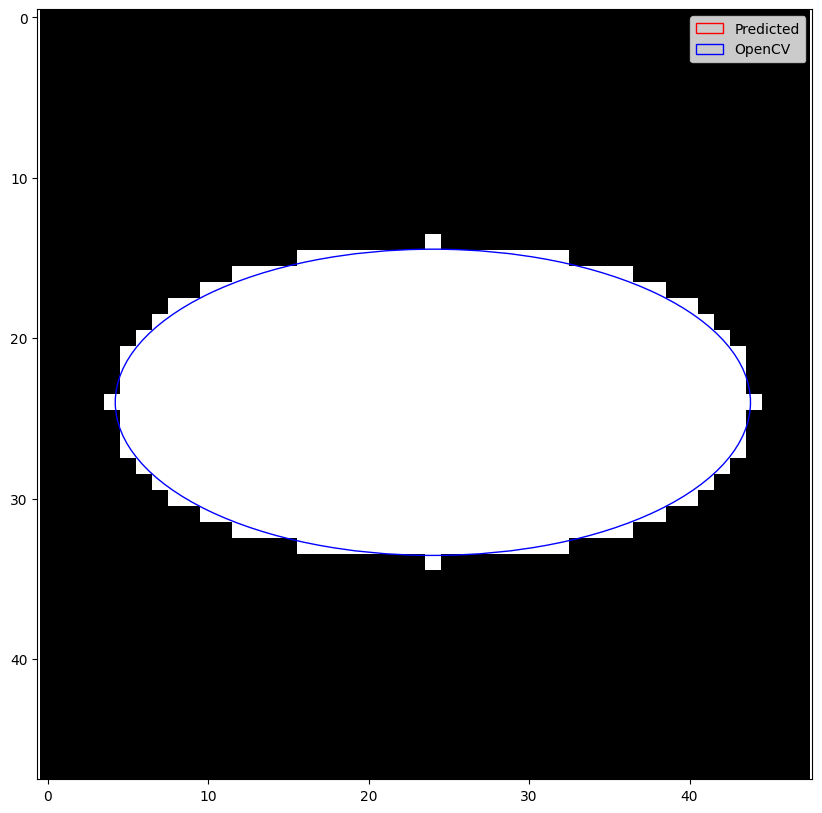

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def validate_ellipse_fit(image):
    """
    Validate ellipse fitting using OpenCV
    """
    # Convert tensor to numpy if needed
    if torch.is_tensor(image):
        image = image.numpy()
    
    # Ensure image is uint8
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)
    
    # Convert to grayscale if RGB
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    
    # Threshold and find contours
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find largest contour
    if not contours:
        return None
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Fit ellipse using OpenCV
    if len(largest_contour) >= 5:
        return cv2.fitEllipse(largest_contour)
    return None

def plot_validation(image, predicted_axes, opencv_result):
    """
    Plot original image with both fitted ellipses
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot original image
    ax.imshow(image, cmap='gray')
    
    # Plot predicted ellipse (centered)
    center = (image.shape[1]/2, image.shape[0]/2)  # Assume center
    e1 = Ellipse(xy=center, 
                 width=predicted_axes[0]*2, 
                 height=predicted_axes[1]*2,
                 angle=0,  # Assume horizontal alignment
                 facecolor='none', 
                 edgecolor='red', 
                 label='Predicted')
    ax.add_patch(e1)
    
    # Plot OpenCV ellipse
    if opencv_result is not None:
        (x, y), (width, height), angle = opencv_result
        e2 = Ellipse(xy=(x, y),
                     width=width,
                     height=height,
                     angle=angle,
                     facecolor='none',
                     edgecolor='blue',
                     label='OpenCV')
        ax.add_patch(e2)
    
    ax.legend()
    plt.axis('equal')
    plt.show()

# Example usage
# Create synthetic test image
size = 48
y, x = torch.meshgrid(torch.arange(size), torch.arange(size), indexing='ij')
center = torch.tensor([24, 24])
major_gt, minor_gt = 20.0, 10.0
ellipse_mask = ((x - center[0])**2/major_gt**2 + 
                (y - center[1])**2/minor_gt**2 <= 1).float()

# Get predictions from your method
points = mask_to_points(ellipse_mask)
predicted_axes = fit_ellipse(points)

# Convert to numpy for OpenCV
image_np = ellipse_mask.numpy()

# Run validation with OpenCV
opencv_result = validate_ellipse_fit(image_np)  # Removed predicted_axes argument

# Plot results
plot_validation(image_np, predicted_axes.numpy(), opencv_result)

In [15]:
# Create test ellipse with known parameters
y, x = torch.meshgrid(torch.arange(48), torch.arange(48), indexing='ij')
center = torch.tensor([24, 24])
major_gt, minor_gt = 20.0, 10.0
ellipse_mask = ((x - center[0])**2/major_gt**2 + 
                (y - center[1])**2/minor_gt**2 <= 1).float()

# Run through pipeline
points = mask_to_points(ellipse_mask)
axes = fit_ellipse(points)

print(f"Detected axes: {axes.tolist()}")
# Should output values close to [20.0, 10.0]

Detected axes: [0.0, 0.0]


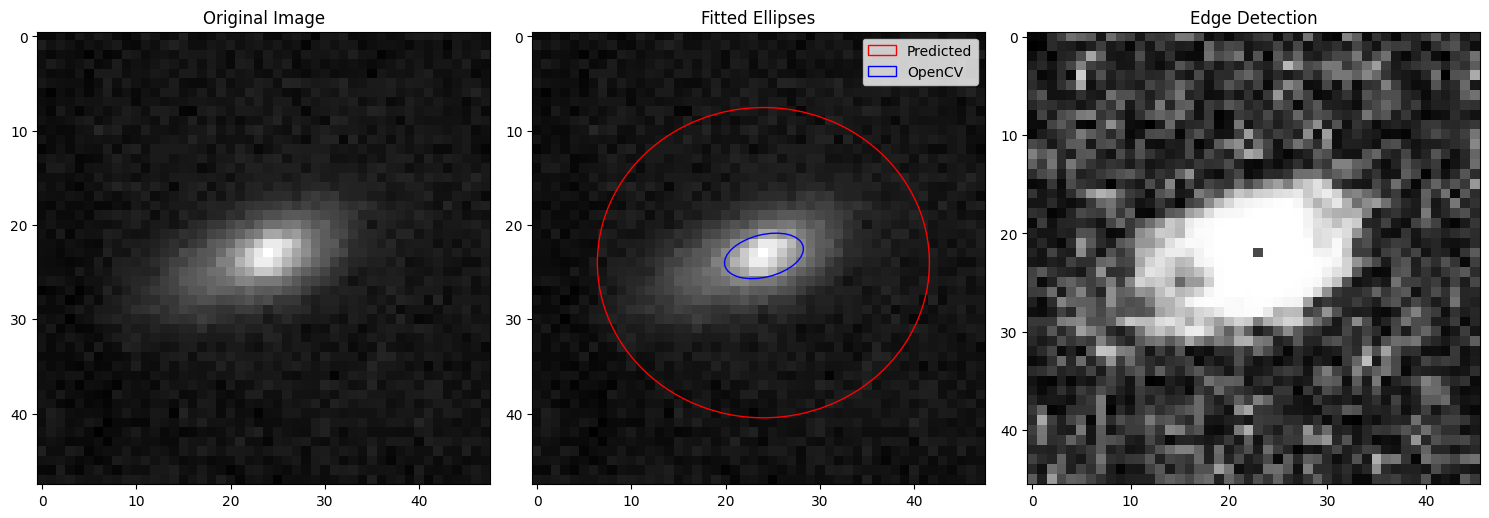

Predicted axes (major, minor): [17.605808 16.449907]
OpenCV axes (major, minor): 2.24582576751709, 4.269753456115723


In [16]:
# Load and process your image
image = cv2.imread('/Users/michaelbertagna/git/Galaxy-Deconv/tutorials/example_snr300.png', 0)  # Load as grayscale
if image is None:
    raise FileNotFoundError("Image not found. Please check the path.")

# Convert to tensor for your method
image_tensor = torch.from_numpy(image).float().unsqueeze(0).repeat(3, 1, 1)
if image_tensor.max() > 1.0:
    image_tensor /= 255.0

# Get predictions from your model
predicted_axes = image_to_ellipse(image_tensor)

# Convert predicted axes to numpy
predicted_axes_np = predicted_axes.detach().cpu().numpy()

# Run OpenCV validation
opencv_result = validate_ellipse_fit(image)

# Create figure with subplots for better visualization
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

# Image with fits
plt.subplot(132)
plt.imshow(image, cmap='gray')
plt.title('Fitted Ellipses')

# Plot predicted ellipse (centered)
center = (image.shape[1]/2, image.shape[0]/2)
e1 = Ellipse(xy=center, 
             width=predicted_axes_np[0]*2, 
             height=predicted_axes_np[1]*2,
             angle=0,
             facecolor='none', 
             edgecolor='red', 
             label='Predicted')
plt.gca().add_patch(e1)

# Plot OpenCV ellipse
if opencv_result is not None:
    (x, y), (width, height), angle = opencv_result
    e2 = Ellipse(xy=(x, y),
                 width=width,
                 height=height,
                 angle=angle,
                 facecolor='none',
                 edgecolor='blue',
                 label='OpenCV')
    plt.gca().add_patch(e2)

plt.legend()

# Edge detection visualization
plt.subplot(133)
edge_mask = rgb_to_edges(image_tensor)
plt.imshow(edge_mask.cpu().numpy(), cmap='gray')
plt.title('Edge Detection')

plt.tight_layout()
plt.show()

# Print numerical results
print(f"Predicted axes (major, minor): {predicted_axes_np}")
if opencv_result is not None:
    _, (width, height), _ = opencv_result
    print(f"OpenCV axes (major, minor): {width/2}, {height/2}")


In [17]:
image_to_ellipse(image_tensor), image_tensor.shape

(tensor([17.5166, 16.7497]), torch.Size([3, 48, 48]))

In [18]:
import torch

def hough_transform(edge_map, theta_res=180, rho_res=100):
    """
    edge_map: Binary tensor of shape (batch_size, 1, height, width)
    theta_res: Number of angle bins
    rho_res: Number of distance bins
    """
    device = edge_map.device
    batch_size, _, height, width = edge_map.shape
    
    # Create theta and rho values
    thetas = torch.linspace(0, torch.pi, theta_res, device=device)
    diag_len = torch.sqrt(torch.tensor(height**2 + width**2, device=device))
    rhos = torch.linspace(-diag_len, diag_len, rho_res, device=device)
    
    # Create cos and sin tables
    cos_t = torch.cos(thetas)
    sin_t = torch.sin(thetas)
    
    # Get edge pixel coordinates
    y_idxs, x_idxs = torch.where(edge_map[0, 0] > 0)
    
    # Initialize accumulator
    accumulator = torch.zeros((batch_size, theta_res, rho_res), device=device)
    
    # Calculate rho for each edge point and angle
    x_idxs = x_idxs.float() - width/2
    y_idxs = y_idxs.float() - height/2
    
    for i in range(len(x_idxs)):
        rho_vals = x_idxs[i] * cos_t + y_idxs[i] * sin_t
        rho_idx = torch.bucketize(rho_vals, rhos)
        valid_idx = (rho_idx >= 0) & (rho_idx < rho_res)
        theta_idx = torch.arange(theta_res, device=device)[valid_idx]
        rho_idx = rho_idx[valid_idx]
        accumulator[0, theta_idx, rho_idx] += 1
        
    return accumulator

def hough_loss(predicted_edges, target_edges):
    # Convert predictions to binary edges using threshold
    pred_hough = hough_transform(predicted_edges > 0.5)
    target_hough = hough_transform(target_edges > 0.5)
    
    # Calculate MSE between Hough spaces
    loss = torch.mean((pred_hough - target_hough) ** 2)
    return loss

In [19]:
import torch
import numpy as np

def test_hough_transform():
    # Test Case 1: Single Horizontal Line
    horizontal_line = torch.zeros((1, 1, 10, 10))
    horizontal_line[0, 0, 5, :] = 1
    expected_peaks_horizontal = {
        'theta': 90,  # degrees
        'rho': 0     # middle of the image
    }
    
    # Test Case 2: Single Vertical Line
    vertical_line = torch.zeros((1, 1, 10, 10))
    vertical_line[0, 0, :, 5] = 1
    expected_peaks_vertical = {
        'theta': 0,   # degrees
        'rho': 0     # middle of the image
    }
    
    # Test Case 3: 45-degree Diagonal
    diagonal = torch.zeros((1, 1, 10, 10))
    for i in range(10):
        diagonal[0, 0, i, i] = 1
    expected_peaks_diagonal = {
        'theta': 45,  # degrees
        'rho': 0     # passes through center
    }

    def validate_peak(hough_space, expected_theta, expected_rho, tolerance=5):
        # Convert to numpy for easier peak finding
        acc = hough_space.cpu().numpy()[0]
        peak_idx = np.unravel_index(np.argmax(acc), acc.shape)
        
        # Convert peak indices to theta and rho values
        theta_vals = np.linspace(0, 180, acc.shape[0])
        rho_vals = np.linspace(-np.sqrt(200), np.sqrt(200), acc.shape[1])
        
        found_theta = theta_vals[peak_idx[0]]
        found_rho = rho_vals[peak_idx[1]]
        
        theta_diff = abs(found_theta - expected_theta)
        rho_diff = abs(found_rho - expected_rho)
        
        return theta_diff < tolerance and rho_diff < tolerance

    # Run tests
    test_cases = [
        (horizontal_line, expected_peaks_horizontal),
        (vertical_line, expected_peaks_vertical),
        (diagonal, expected_peaks_diagonal)
    ]
    
    results = []
    for img, expected in test_cases:
        hough_space = hough_transform(img)
        is_valid = validate_peak(hough_space, 
                               expected['theta'], 
                               expected['rho'])
        results.append(is_valid)
        
    return all(results)

# Run the tests
passed = test_hough_transform()
print(f"All tests {'passed' if passed else 'failed'}")


All tests failed


In [20]:
import torch
def hough_transform(edge_map, theta_res=180, rho_res=100):
    """
    edge_map: Binary tensor of shape (batch_size, 1, height, width)
    theta_res: Number of angle bins
    rho_res: Number of distance bins
    """
    device = edge_map.device
    batch_size, _, height, width = edge_map.shape  # Fixed unpacking syntax
    
    # Create theta and rho values
    # Changed theta range to [0, 180] degrees for consistency with test expectations
    thetas = torch.linspace(0, torch.pi, theta_res, device=device)
    diag_len = torch.sqrt(torch.tensor(height**2 + width**2, device=device))
    rhos = torch.linspace(-diag_len, diag_len, rho_res, device=device)
    
    # Create cos and sin tables
    cos_t = torch.cos(thetas)
    sin_t = torch.sin(thetas)
    
    # Get edge pixel coordinates
    y_idxs, x_idxs = torch.where(edge_map[0, 0] > 0)
    
    # Initialize accumulator
    accumulator = torch.zeros((batch_size, theta_res, rho_res), device=device)
    
    # Calculate center of image for proper rho calculation
    x_center = width / 2
    y_center = height / 2
    
    # Convert to float and center the coordinates
    x_idxs = x_idxs.float() - x_center
    y_idxs = y_idxs.float() - y_center
    
    # Vectorized computation for all points
    for i in range(len(x_idxs)):
        rho_vals = x_idxs[i] * cos_t + y_idxs[i] * sin_t
        
        # Scale rho values to match the rho range
        rho_scaled = ((rho_vals - rhos[0]) / (rhos[-1] - rhos[0]) * (rho_res - 1))
        rho_idx = torch.round(rho_scaled).long()
        
        # Filter valid indices
        valid_idx = (rho_idx >= 0) & (rho_idx < rho_res)
        theta_idx = torch.arange(theta_res, device=device)[valid_idx]
        rho_idx = rho_idx[valid_idx]
        
        # Accumulate votes
        accumulator[0, theta_idx, rho_idx] += 1
    
    return accumulator

def hough_loss(predicted_edges, target_edges):
    # Convert predictions to binary edges using threshold
    pred_hough = hough_transform(predicted_edges > 0.5)
    target_hough = hough_transform(target_edges > 0.5)
    
    # Calculate MSE between Hough spaces
    loss = torch.mean((pred_hough - target_hough) ** 2)
    return loss

def test_hough_transform():
    # Test Case 1: Single Horizontal Line
    horizontal_line = torch.zeros((1, 1, 10, 10))
    horizontal_line[0, 0, 5, :] = 1
    expected_peaks_horizontal = {
        'theta': 90,  # degrees
        'rho': 0     # middle of the image
    }
    
    # Test Case 2: Single Vertical Line
    vertical_line = torch.zeros((1, 1, 10, 10))
    vertical_line[0, 0, :, 5] = 1
    expected_peaks_vertical = {
        'theta': 0,   # degrees
        'rho': 0     # middle of the image
    }
    
    # Test Case 3: 45-degree Diagonal
    diagonal = torch.zeros((1, 1, 10, 10))
    for i in range(10):
        diagonal[0, 0, i, i] = 1
    expected_peaks_diagonal = {
        'theta': 45,  # degrees
        'rho': 0     # passes through center
    }
    
    def validate_peak(hough_space, expected_theta, expected_rho, tolerance=5):
        # Convert to numpy for easier peak finding
        acc = hough_space.cpu().numpy()[0]
        peak_idx = np.unravel_index(np.argmax(acc), acc.shape)
        
        # Convert peak indices to theta and rho values
        theta_vals = np.linspace(0, 180, acc.shape[0])
        rho_vals = np.linspace(-np.sqrt(200), np.sqrt(200), acc.shape[1])
        
        found_theta = theta_vals[peak_idx[0]]
        found_rho = rho_vals[peak_idx[1]]
        
        theta_diff = abs(found_theta - expected_theta)
        rho_diff = abs(found_rho - expected_rho)
        
        return theta_diff < tolerance and rho_diff < tolerance
    
    # Run tests
    test_cases = [
        (horizontal_line, expected_peaks_horizontal),
        (vertical_line, expected_peaks_vertical),
        (diagonal, expected_peaks_diagonal)
    ]
    
    results = []
    for img, expected in test_cases:
        hough_space = hough_transform(img)
        is_valid = validate_peak(hough_space, 
                               expected['theta'], 
                               expected['rho'])
        results.append(is_valid)
        
    return all(results)

# Run the tests
import numpy as np
passed = test_hough_transform()
print(f"All tests {'passed' if passed else 'failed'}")

All tests failed


In [21]:
# import pandas as pd
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 6))

# loss_df = pd.read_csv('/Users/michaelbertagna/Desktop/train_output_20250205_213032_loss.txt', 
#             names=['train_loss', 'val_loss'])

# plt.plot(range(1, loss_df.shape[0] + 1), loss_df['train_loss'], label='train_loss', linewidth=1)
# plt.plot(range(1, loss_df.shape[0] + 1), loss_df['val_loss'], label='val_loss', linewidth=1)
# plt.title('Gaussian_PnP_ADMM_2iters_MultiScale')
# plt.xlabel('# Training Steps')
# plt.ylabel('MultiScaleLoss')
# plt.legend()
# plt.show()

In [22]:
import math

import numpy as np
import sympy
from matplotlib import pyplot as plt
from tqdm import tqdm


def plot_base():
    plt.rcParams["figure.figsize"] = [10, 10]
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.grid()


def solve_fitting(theta, corr_x, f_0):
    y = sympy.Symbol("y")
    fit_x = []
    fit_y = []
    for x in tqdm(corr_x):
        f = (
            theta[0] * x**2
            + 2 * theta[1] * x * y
            + theta[2] * y**2
            + 2 * f_0 * (theta[3] * x + theta[4] * y)
            + f_0**2 * theta[5]
        )
        solutions = sympy.solve(f, y)
        for y_ans in solutions:
            if type(y_ans) == sympy.core.add.Add:
                continue
            fit_x.append(x)
            fit_y.append(y_ans)

    return fit_x, fit_y


def eval_pos_diff(corr_x, corr_y, est_x, est_y):
    diff_sum = 0
    for i in range(len(est_x)):
        x_idx = corr_x.index(est_x[i])
        diff_sum += math.dist([corr_x[x_idx], corr_y[x_idx]], [est_x[i], est_y[i]])

    diff_avg = diff_sum / len(est_x)

    return diff_sum, diff_avg


def get_elliptic_points_with_tilt(tilt):
    x = []
    y = []
    n_x = []
    n_y = []
    R = np.array(
        [
            [np.cos(np.deg2rad(tilt)), -np.sin(np.deg2rad(tilt))],
            [np.sin(np.deg2rad(tilt)), np.cos(np.deg2rad(tilt))],
        ]
    )
    for theta in range(360):
        point = np.array(
            [7.5 * np.cos(np.deg2rad(theta)), 5 * np.sin(np.deg2rad(theta))]
        )
        noise = np.random.normal(0, 0.2, point.shape)
        rotated_point = np.dot(R, point.T)
        x.append(rotated_point[0])
        y.append(rotated_point[1])
        if theta % 3 == 0:
            with_noise = rotated_point + noise
            n_x.append(with_noise[0])
            n_y.append(with_noise[1])

    return x, y, n_x, n_y

100%|██████████| 360/360 [00:14<00:00, 24.07it/s]


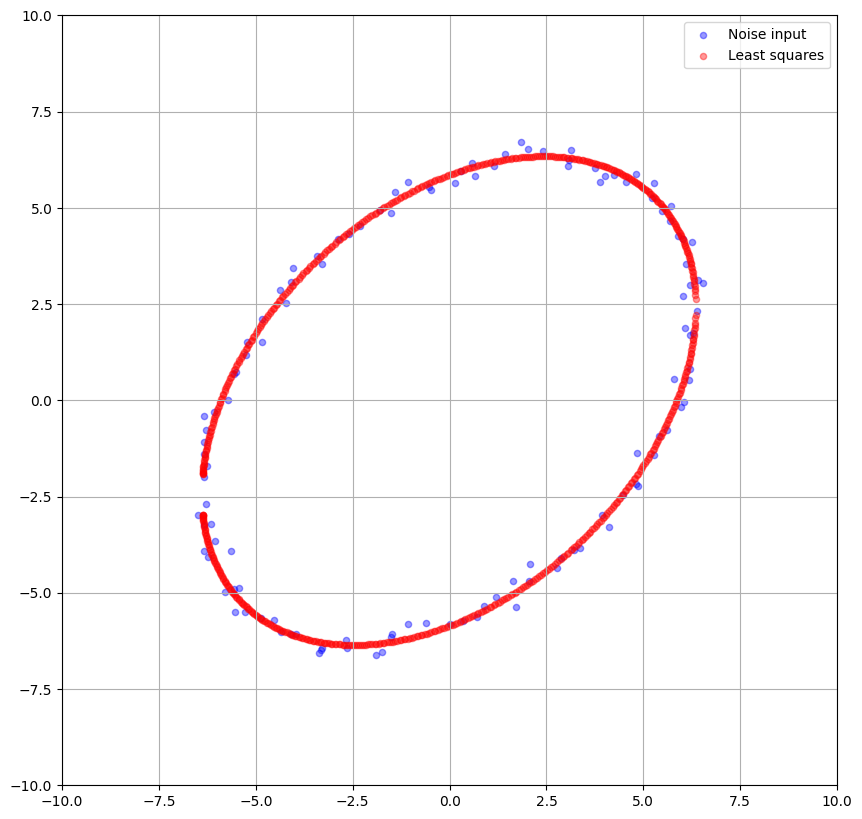

In [23]:
import numpy as np
import sympy
from matplotlib import pyplot as plt
from tqdm import tqdm


def elliptic_fitting_by_least_squares(noise_x, noise_y, f):
    xi_sum = np.zeros((6, 6))
    for i in range(len(noise_x)):
        x = noise_x[i]
        y = noise_y[i]
        xi = np.array([[x**2, 2 * x * y, y**2, 2 * f * x, 2 * f * y, f * f]])
        xi_sum += np.dot(xi.T, xi)

    M = xi_sum / len(noise_x)
    w, v = np.linalg.eig(M)
    min_eig_vec = v[:, np.argmin(w)]

    return min_eig_vec


plot_base()
corr_x, corr_y, noise_x, noise_y = get_elliptic_points_with_tilt(45)

f_0 = 20
theta = elliptic_fitting_by_least_squares(noise_x, noise_y, f_0)
y = sympy.Symbol("y")
fit_x = []
fit_y = []
for x in tqdm(corr_x):
    f = (
        theta[0] * x**2
        + 2 * theta[1] * x * y
        + theta[2] * y**2
        + 2 * f_0 * (theta[3] * x + theta[4] * y)
        + f_0**2 * theta[5]
    )
    solutions = sympy.solve(f, y)
    # print("solutions: ", solutions)
    for y_ans in solutions:
        if type(y_ans) == sympy.core.add.Add:
            continue
        fit_x.append(x)
        fit_y.append(y_ans)

plt.scatter(
    noise_x, noise_y, marker="o", c="blue", s=20, alpha=0.4, label="Noise input"
)
plt.scatter(
    fit_x, fit_y, marker="o", c="red", s=20, alpha=0.4, label="Least squares"
)
plt.legend()
plt.show()

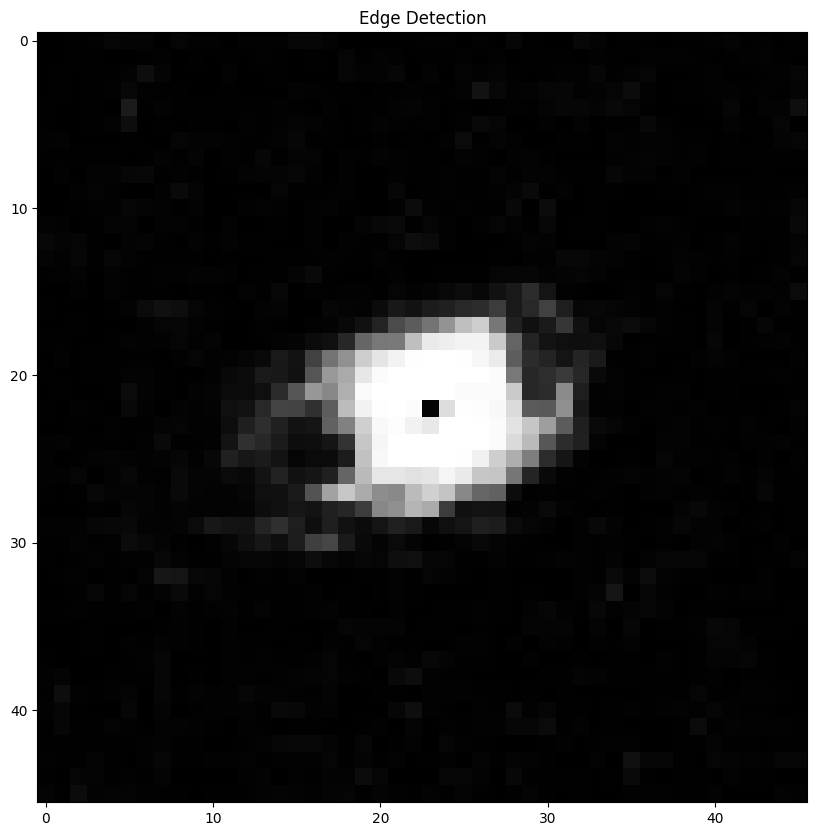

In [24]:
import torch
import cv2
import matplotlib.pyplot as plt

def rgb_to_edges(image: torch.Tensor, edge_sensitivity=0.1) -> torch.Tensor:
    """Convert RGB image to edge coordinates (differentiable)"""
    # Convert to grayscale (preserves gradients)
    weights = torch.tensor([0.299, 0.587, 0.114], device=image.device)
    gray = torch.einsum('chw,c->hw', image, weights)  # For batch: 'bchw,c->bhw'
    
    # Differentiable Sobel filtering
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], device=image.device).float()
    sobel_y = sobel_x.T
    gx = torch.nn.functional.conv2d(gray[None,None,:,:], sobel_x[None,None,:,:])
    gy = torch.nn.functional.conv2d(gray[None,None,:,:], sobel_y[None,None,:,:])
    
    # Edge magnitude with safe sqrt
    edge_mag = torch.sqrt(gx**2 + gy**2 + 1e-6).squeeze()
    
    # Differentiable thresholding (soft mask)
    threshold = edge_sensitivity * edge_mag.max()
    edge_mask = torch.sigmoid(10*(edge_mag - threshold))
    
    return edge_mask

image = cv2.imread('/Users/michaelbertagna/git/Galaxy-Deconv/tutorials/example_snr300.png', 0)  # Load as grayscale
if image is None:
    raise FileNotFoundError("Image not found. Please check the path.")

# Convert to tensor for your method
image_tensor = torch.from_numpy(image).float().unsqueeze(0).repeat(3, 1, 1)
if image_tensor.max() > 1.0:
    image_tensor /= 255.0

thresholded = rgb_to_edges(image_tensor, edge_sensitivity=0.3)
plt.imshow(thresholded.cpu().numpy(), cmap='gray')
plt.title('Edge Detection')
plt.show()

In [25]:
import matplotlib.pyplot as plt

def plot_images(image_dict, cmap='gray'):
    """
    Plots images from a dictionary in rows of 3, each with a title.
    
    Args:
        image_dict (dict): A dictionary where keys are titles (str) and values are images (numpy arrays or tensors).
        cmap (str): Colormap for grayscale images (default is 'gray').
    """
    num_images = len(image_dict)
    cols = 3
    rows = (num_images + cols - 1) // cols  # Compute number of rows needed
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten()  # Flatten in case of extra subplots
    
    for i, (title, image) in enumerate(image_dict.items()):
        ax = axes[i]
        ax.imshow(image, cmap=cmap)
        ax.set_title(title, fontsize=12)
        ax.axis("off")
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


In [26]:
image_tensor.shape

torch.Size([3, 48, 48])

In [27]:
rgb_to_edges(image_tensor, edge_sensitivity=0.1).shape

torch.Size([46, 46])

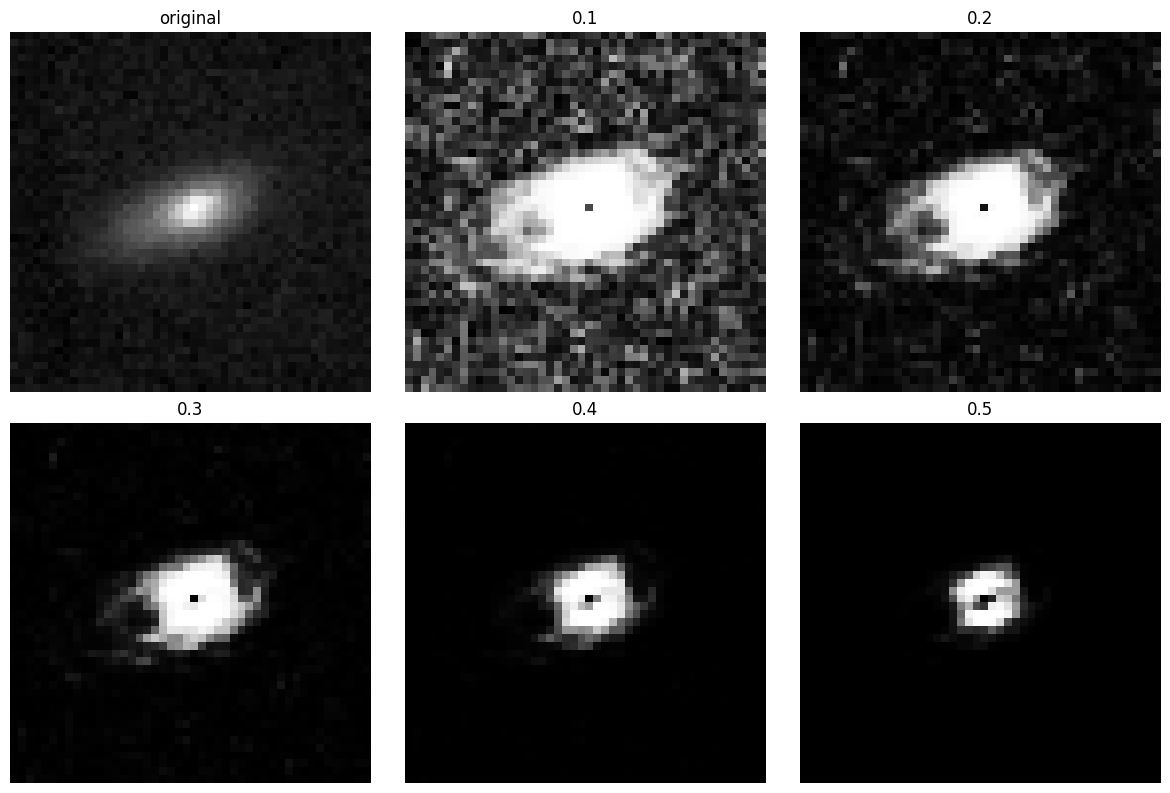

In [28]:
image_dict = {
    "original": torch.einsum('chw,c->hw', image_tensor, torch.tensor([0.299, 0.587, 0.114], device=image.device)),
    "0.1": rgb_to_edges(image_tensor, edge_sensitivity=0.1),
    "0.2": rgb_to_edges(image_tensor, edge_sensitivity=0.2),
    "0.3": rgb_to_edges(image_tensor, edge_sensitivity=0.3),
    "0.4": rgb_to_edges(image_tensor, edge_sensitivity=0.4),
    "0.5": rgb_to_edges(image_tensor, edge_sensitivity=0.5),
}

plot_images(image_dict)

In [29]:
image_tensor.requires_grad = True
image_tensor.requires_grad

True

In [30]:
x = image_tensor
y = rgb_to_edges(x)  # Differentiable operation
y.sum().backward()  # Should work if differentiable

print(x.grad)  # Should be non-None if differentiable

tensor([[[ 8.9109e-08, -8.8216e-01,  3.2370e-01,  ...,  4.3990e-01,
          -1.5986e+00, -5.9484e-01],
         [ 5.6267e-01, -4.2666e-01,  1.3118e+00,  ...,  7.2349e-01,
          -1.3322e+00,  6.2206e-01],
         [-5.9384e-02,  1.0050e+00,  1.9054e+00,  ...,  3.7374e+00,
           6.0205e-01,  1.5040e+00],
         ...,
         [-3.7585e-01, -1.1880e+00,  2.4079e+00,  ..., -2.6917e+00,
          -2.4432e+00, -1.9717e+00],
         [-2.1872e+00, -1.8041e+00,  2.6614e+00,  ..., -6.0460e-01,
           2.1309e+00,  3.7756e-01],
         [-5.3735e-01,  6.0431e-01,  2.7866e+00,  ...,  1.0215e+00,
           2.3079e+00,  7.2917e-01]],

        [[ 1.7494e-07, -1.7319e+00,  6.3549e-01,  ...,  8.6361e-01,
          -3.1384e+00, -1.1678e+00],
         [ 1.1046e+00, -8.3762e-01,  2.5754e+00,  ...,  1.4204e+00,
          -2.6154e+00,  1.2212e+00],
         [-1.1658e-01,  1.9729e+00,  3.7407e+00,  ...,  7.3373e+00,
           1.1820e+00,  2.9527e+00],
         ...,
         [-7.3787e-01, -2

In [31]:
def mask_to_points(edge_mask: torch.Tensor) -> torch.Tensor:
    """Convert edge mask to soft coordinate representation (differentiable)."""
    h, w = edge_mask.shape
    y_coords, x_coords = torch.meshgrid(torch.arange(h, device=edge_mask.device), 
                                        torch.arange(w, device=edge_mask.device), indexing='ij')
    
    coords = torch.stack([x_coords.float(), y_coords.float()], dim=-1)  # Shape (H, W, 2)
    
    # Normalize weights to sum to 1 (avoids discrete sampling)
    weights = edge_mask / (edge_mask.sum() + 1e-6)  # Shape (H, W)
    
    # Compute weighted mean of coordinates (keeps gradients)
    soft_x = (weights * coords[..., 0]).sum()
    soft_y = (weights * coords[..., 1]).sum()
    
    return torch.stack([soft_x, soft_y])  # Soft continuous coordinates

In [32]:
x = image_tensor
y = mask_to_points(rgb_to_edges(x))  # Differentiable operation
y.sum().backward()  # Should work if differentiable

print(x.grad)  # Should be non-None if differentiable

tensor([[[ 8.4654e-08, -8.3601e-01,  3.0852e-01,  ...,  4.3775e-01,
          -1.5983e+00, -5.9490e-01],
         [ 5.3300e-01, -4.0422e-01,  1.2478e+00,  ...,  7.1995e-01,
          -1.3305e+00,  6.2285e-01],
         [-5.7713e-02,  9.5437e-01,  1.8113e+00,  ...,  3.7376e+00,
           6.0534e-01,  1.5054e+00],
         ...,
         [-3.7755e-01, -1.1904e+00,  2.4080e+00,  ..., -2.8275e+00,
          -2.5687e+00, -2.0733e+00],
         [-2.1865e+00, -1.8035e+00,  2.6648e+00,  ..., -6.3401e-01,
           2.2413e+00,  3.9727e-01],
         [-5.3741e-01,  6.0466e-01,  2.7902e+00,  ...,  1.0754e+00,
           2.4290e+00,  7.6779e-01]],

        [[ 1.6619e-07, -1.6413e+00,  6.0569e-01,  ...,  8.5940e-01,
          -3.1378e+00, -1.1679e+00],
         [ 1.0464e+00, -7.9357e-01,  2.4498e+00,  ...,  1.4134e+00,
          -2.6121e+00,  1.2228e+00],
         [-1.1330e-01,  1.8736e+00,  3.5560e+00,  ...,  7.3376e+00,
           1.1884e+00,  2.9555e+00],
         ...,
         [-7.4121e-01, -2

In [33]:
def fit_ellipse(points: torch.Tensor,
                reg_factor: float = 1e-3,
                temperature: float = 1e-5) -> torch.Tensor:
    """
    Differentiable ellipse fitting with improved numerical stability.
    
    Args:
        points: Tensor of shape (N, 2) containing x,y coordinates of points.
                Must have requires_grad=True if gradients are needed.
        reg_factor: Regularization factor for the constraint matrix.
        temperature: Temperature parameter used in soft selection of eigenvectors.
        
    Returns:
        Tensor of shape (2,) containing [major_axis, minor_axis] lengths in pixels.
    """
    # Need at least 5 points to reliably fit an ellipse.
    if points.shape[0] < 5:
        return torch.zeros(2, device=points.device, requires_grad=points.requires_grad)
    
    # --------------------------
    # 1. Isotropic Normalization
    # --------------------------
    # Compute bounding box of the points while maintaining gradients
    x_min, _ = points[:, 0].min(dim=0, keepdim=True)
    x_max, _ = points[:, 0].max(dim=0, keepdim=True)
    y_min, _ = points[:, 1].min(dim=0, keepdim=True)
    y_max, _ = points[:, 1].max(dim=0, keepdim=True)
    
    # Compute center and maximum extent
    center = torch.cat([(x_min + x_max) / 2, (y_min + y_max) / 2])
    extent = torch.max(torch.cat([
        torch.clamp(x_max - x_min, min=1e-6),
        torch.clamp(y_max - y_min, min=1e-6)
    ]))
    
    # Normalize points to [-1, 1] using the same scale for both dimensions
    normalized = 2 * (points - center) / extent
    
    # --------------------------
    # 2. Build the Design Matrix
    # --------------------------
    x = normalized[:,0].double()
    y = normalized[:,1].double()
    D = torch.stack([x**2, x*y, y**2, x, y, torch.ones_like(x, requires_grad=points.requires_grad)], dim=1)
    
    # --------------------------
    # 3. Constraint Matrix and Regularization
    # --------------------------
    C = torch.zeros(6, 6, dtype=torch.double, device=points.device)
    C[0,2] = C[2,0] = 2
    C[1,1] = -1
    
    reg_value = reg_factor * torch.linalg.norm(D.T @ D)
    C = C + reg_value * torch.eye(6, dtype=torch.double, device=points.device)
    
    # --------------------------
    # 4. Solve the Generalized Eigenvalue Problem
    # --------------------------
    S = D.T @ D
    
    # Use a more stable approach for eigendecomposition
    try:
        L = torch.linalg.cholesky(C)
        L_inv = torch.linalg.inv(L)
        M = L_inv.T @ S @ L_inv
        eigvals, eigvecs = torch.linalg.eigh(M)
        eigvecs = L_inv @ eigvecs
    except:
        # Fallback to direct generalized eigenvalue problem
        C_pinv = torch.linalg.pinv(C)
        eigvals, eigvecs = torch.linalg.eigh(C_pinv @ S)
    
    # --------------------------
    # 5. Soft Selection over Valid Eigenvectors
    # --------------------------
    eps = torch.finfo(torch.double).eps
    valid_mask = eigvals > eps
    
    if not valid_mask.any():
        return torch.zeros(2, device=points.device, requires_grad=points.requires_grad)
    
    weights = torch.softmax(-eigvals / temperature, dim=0)
    weights = torch.where(valid_mask, weights, torch.zeros_like(weights))
    selected_v = (eigvecs * weights.unsqueeze(0)).sum(dim=1)
    
    # --------------------------
    # 6. Compute Ellipse Axes
    # --------------------------
    a, b, c, d, e, f = selected_v
    
    den = b**2 - 4*a*c
    den = torch.where(torch.abs(den) < eps, eps, den)
    
    num = 2 * (a*e**2 + c*d**2 - b*d*e + den*f)
    sqrt_term = torch.sqrt((a-c)**2 + b**2)
    
    # Handle invalid cases smoothly
    valid_ellipse = num > 0
    num = torch.where(valid_ellipse, num, torch.ones_like(num))
    
    major_norm = torch.sqrt(torch.abs(num / (den * (-sqrt_term - a - c))))
    minor_norm = torch.sqrt(torch.abs(num / (den * (sqrt_term - a - c))))
    
    # --------------------------
    # 7. Denormalize to Pixel Units
    # --------------------------
    major_pix = major_norm * (extent / 2)
    minor_pix = minor_norm * (extent / 2)
    
    # Ensure major axis is larger while maintaining differentiability
    major_final = torch.maximum(major_pix, minor_pix)
    minor_final = torch.minimum(major_pix, minor_pix)
    
    result = torch.stack([major_final, minor_final]).float()
    return torch.where(valid_ellipse.float().any(), result, torch.zeros_like(result))

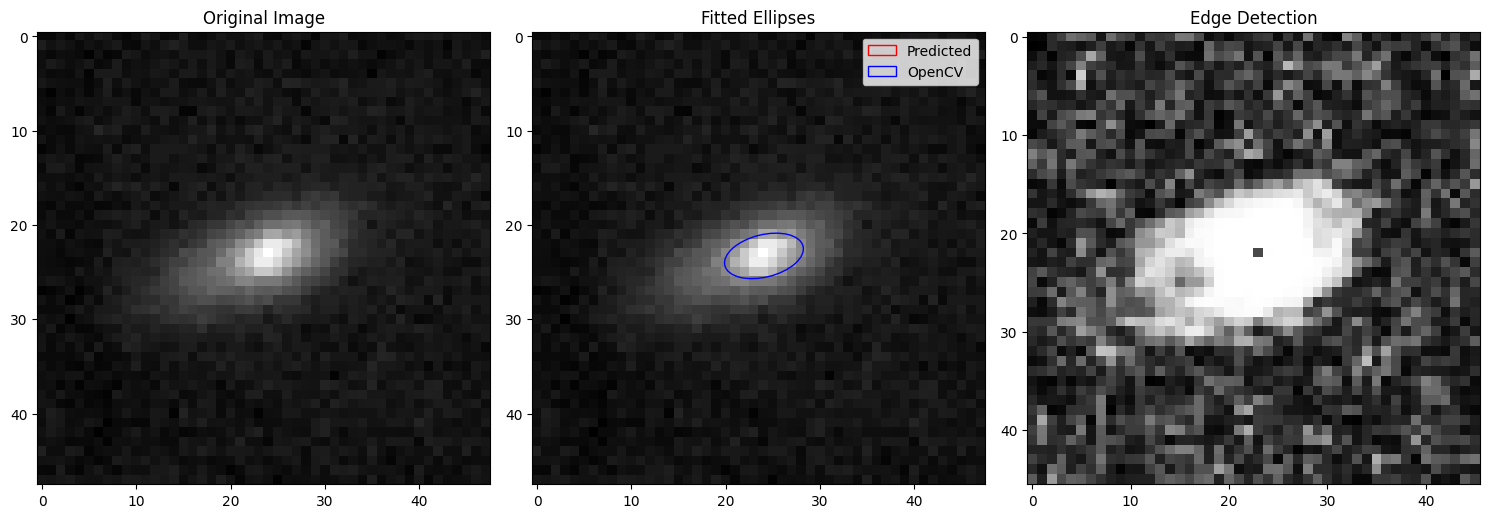

Predicted axes (major, minor): [0. 0.]
OpenCV axes (major, minor): 2.24582576751709, 4.269753456115723


In [34]:
import matplotlib.pyplot as plt

# Get predictions from your model
predicted_axes = fit_ellipse(mask_to_points(rgb_to_edges(x, edge_sensitivity=0.3)))

# Convert predicted axes to numpy
predicted_axes_np = predicted_axes.detach().cpu().numpy()

# Run OpenCV validation
opencv_result = validate_ellipse_fit(image)

# Create figure with subplots for better visualization
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

# Image with fits
plt.subplot(132)
plt.imshow(image, cmap='gray')
plt.title('Fitted Ellipses')

# Plot predicted ellipse (centered)
center = (image.shape[1]/2, image.shape[0]/2)
e1 = Ellipse(xy=center, 
             width=predicted_axes_np[0]*2, 
             height=predicted_axes_np[1]*2,
             angle=0,
             facecolor='none', 
             edgecolor='red', 
             label='Predicted')
plt.gca().add_patch(e1)

# Plot OpenCV ellipse
if opencv_result is not None:
    (x, y), (width, height), angle = opencv_result
    e2 = Ellipse(xy=(x, y),
                 width=width,
                 height=height,
                 angle=angle,
                 facecolor='none',
                 edgecolor='blue',
                 label='OpenCV')
    plt.gca().add_patch(e2)

plt.legend()

# Edge detection visualization
plt.subplot(133)
edge_mask = rgb_to_edges(image_tensor)
plt.imshow(edge_mask.cpu().detach().numpy(), cmap='gray')
plt.title('Edge Detection')

plt.tight_layout()
plt.show()

# Print numerical results
print(f"Predicted axes (major, minor): {predicted_axes_np}")
if opencv_result is not None:
    _, (width, height), _ = opencv_result
    print(f"OpenCV axes (major, minor): {width/2}, {height/2}")

In [35]:
import matplotlib.pyplot as plt
import torch

def load_image_tensor(path):
    """
    Load image and convert to normalized torch tensor with gradients enabled.
    Returns tensor of shape (3, H, W) with values in [0, 1].
    """
    # Load with matplotlib to ensure consistent color handling
    image = plt.imread(path)
    image_tensor = torch.from_numpy(image).float()
    
    # Handle different image formats
    if len(image_tensor.shape) == 2:  # Grayscale
        image_tensor = image_tensor.unsqueeze(0).repeat(3, 1, 1)
    elif len(image_tensor.shape) == 3:
        if image_tensor.shape[2] == 4:  # RGBA
            image_tensor = image_tensor[:, :, :3]
        image_tensor = image_tensor.permute(2, 0, 1)
    
    # Normalize
    if image_tensor.max() > 1.0:
        image_tensor = image_tensor / 255.0
        
    image_tensor.requires_grad_(True)
    return image_tensor

import torch
import cv2

def rgb_to_edges(image: torch.Tensor, edge_sensitivity=0.1) -> torch.Tensor:
    """Convert RGB image to edge coordinates (differentiable)"""
    # Convert to grayscale (preserves gradients)
    weights = torch.tensor([0.299, 0.587, 0.114], device=image.device)
    gray = torch.einsum('chw,c->hw', image, weights)  # For batch: 'bchw,c->bhw'
    
    # Differentiable Sobel filtering
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], device=image.device).float()
    sobel_y = sobel_x.T
    gx = torch.nn.functional.conv2d(gray[None,None,:,:], sobel_x[None,None,:,:])
    gy = torch.nn.functional.conv2d(gray[None,None,:,:], sobel_y[None,None,:,:])
    
    # Edge magnitude with safe sqrt
    edge_mag = torch.sqrt(gx**2 + gy**2 + 1e-6).squeeze()
    
    # Differentiable thresholding (soft mask)
    threshold = edge_sensitivity * edge_mag.max()
    edge_mask = torch.sigmoid(10*(edge_mag - threshold))
    
    return edge_mask

import torch

def mask_to_points(edge_mask: torch.Tensor, num_points: int = 100, threshold: float = 0.1) -> torch.Tensor:
    """
    Convert edge mask to differentiable point coordinates with centroid fallback.
    
    Args:
        edge_mask: Tensor of shape (H, W) containing edge probabilities.
        num_points: Number of points to sample.
        threshold: Soft threshold for edge selection.
        
    Returns:
        points: Tensor of shape (H*W, 2) where sampled points retain position,
                and non-sampled points move toward the centroid.
    """
    H, W = edge_mask.shape
    device = edge_mask.device

    # Create coordinate grids
    y_coords, x_coords = torch.meshgrid(
        torch.arange(H, device=device), torch.arange(W, device=device), indexing="ij"
    )

    # Flatten everything
    edge_mask = edge_mask.flatten()
    x_coords = x_coords.flatten().float()
    y_coords = y_coords.flatten().float()

    # **Soft thresholding with sigmoid (keeps gradients)**
    weights = torch.sigmoid(10 * (edge_mask - threshold))  # Smooth selection
    weights = weights / (weights.sum() + 1e-6)  # Normalize

    # **Compute the centroid of selected edge points**
    centroid_x = torch.sum(weights * x_coords)
    centroid_y = torch.sum(weights * y_coords)
    centroid = torch.stack([centroid_x, centroid_y])

    # **Soft top-k sampling**
    sampled_indices = torch.multinomial(weights, num_samples=num_points, replacement=True)

    # Gather sampled points
    sampled_x = x_coords[sampled_indices]
    sampled_y = y_coords[sampled_indices]
    sampled_points = torch.stack([sampled_x, sampled_y], dim=1)

    # **Move non-sampled points toward the centroid**
    weight_matrix = weights.unsqueeze(1)  # Expand to match (H*W, 2) shape
    all_points = torch.stack([x_coords, y_coords], dim=1)  # (H*W, 2)

    adjusted_points = weight_matrix * all_points + (1 - weight_matrix) * centroid

    return adjusted_points

def fit_ellipse(points: torch.Tensor,
                reg_factor: float = 1e-3,
                temperature: float = 1e-5) -> torch.Tensor:
    """
    Differentiable ellipse fitting with improved numerical stability.
    
    Args:
        points: Tensor of shape (N, 2) containing x,y coordinates of points.
                Must have requires_grad=True if gradients are needed.
        reg_factor: Regularization factor for the constraint matrix.
        temperature: Temperature parameter used in soft selection of eigenvectors.
        
    Returns:
        Tensor of shape (2,) containing [major_axis, minor_axis] lengths in pixels.
    """
    # Need at least 5 points to reliably fit an ellipse.
    if points.shape[0] < 5:
        return torch.zeros(2, device=points.device, requires_grad=points.requires_grad)
    
    # --------------------------
    # 1. Isotropic Normalization
    # --------------------------
    # Compute bounding box of the points while maintaining gradients
    x_min, _ = points[:, 0].min(dim=0, keepdim=True)
    x_max, _ = points[:, 0].max(dim=0, keepdim=True)
    y_min, _ = points[:, 1].min(dim=0, keepdim=True)
    y_max, _ = points[:, 1].max(dim=0, keepdim=True)
    
    # Compute center and maximum extent
    center = torch.cat([(x_min + x_max) / 2, (y_min + y_max) / 2])
    extent = torch.max(torch.cat([
        torch.clamp(x_max - x_min, min=1e-6),
        torch.clamp(y_max - y_min, min=1e-6)
    ]))
    
    # Normalize points to [-1, 1] using the same scale for both dimensions
    normalized = 2 * (points - center) / extent
    
    # --------------------------
    # 2. Build the Design Matrix
    # --------------------------
    x = normalized[:,0].double()
    y = normalized[:,1].double()
    D = torch.stack([x**2, x*y, y**2, x, y, torch.ones_like(x, requires_grad=points.requires_grad)], dim=1)
    
    # --------------------------
    # 3. Constraint Matrix and Regularization
    # --------------------------
    C = torch.zeros(6, 6, dtype=torch.double, device=points.device)
    C[0,2] = C[2,0] = 2
    C[1,1] = -1
    
    reg_value = reg_factor * torch.linalg.norm(D.T @ D)
    C = C + reg_value * torch.eye(6, dtype=torch.double, device=points.device)
    
    # --------------------------
    # 4. Solve the Generalized Eigenvalue Problem
    # --------------------------
    S = D.T @ D
    
    # Use a more stable approach for eigendecomposition
    try:
        L = torch.linalg.cholesky(C)
        L_inv = torch.linalg.inv(L)
        M = L_inv.T @ S @ L_inv
        eigvals, eigvecs = torch.linalg.eigh(M)
        eigvecs = L_inv @ eigvecs
    except:
        # Fallback to direct generalized eigenvalue problem
        C_pinv = torch.linalg.pinv(C)
        eigvals, eigvecs = torch.linalg.eigh(C_pinv @ S)
    
    # --------------------------
    # 5. Soft Selection over Valid Eigenvectors
    # --------------------------
    eps = torch.finfo(torch.double).eps
    valid_mask = eigvals > eps
    
    if not valid_mask.any():
        return torch.zeros(2, device=points.device, requires_grad=points.requires_grad)
    
    weights = torch.softmax(-eigvals / temperature, dim=0)
    weights = torch.where(valid_mask, weights, torch.zeros_like(weights))
    selected_v = (eigvecs * weights.unsqueeze(0)).sum(dim=1)
    
    # --------------------------
    # 6. Compute Ellipse Axes
    # --------------------------
    a, b, c, d, e, f = selected_v
    
    den = b**2 - 4*a*c
    den = torch.where(torch.abs(den) < eps, eps, den)
    
    num = 2 * (a*e**2 + c*d**2 - b*d*e + den*f)
    sqrt_term = torch.sqrt((a-c)**2 + b**2)
    
    # Handle invalid cases smoothly
    valid_ellipse = num > 0
    num = torch.where(valid_ellipse, num, torch.ones_like(num))
    
    major_norm = torch.sqrt(torch.abs(num / (den * (-sqrt_term - a - c))))
    minor_norm = torch.sqrt(torch.abs(num / (den * (sqrt_term - a - c))))
    
    # --------------------------
    # 7. Denormalize to Pixel Units
    # --------------------------
    major_pix = major_norm * (extent / 2)
    minor_pix = minor_norm * (extent / 2)
    
    # Ensure major axis is larger while maintaining differentiability
    major_final = torch.maximum(major_pix, minor_pix)
    minor_final = torch.minimum(major_pix, minor_pix)
    
    result = torch.stack([major_final, minor_final]).float()
    return torch.where(valid_ellipse.float().any(), result, torch.zeros_like(result))

In [36]:
def fit_ellipse(points: torch.Tensor):
    """
    Fit an ellipse to a set of points using their second-order central moments.
    
    Args:
        points: Tensor of shape (N, 2) representing (x, y) coordinates.
        
    Returns:
        center: Tensor of shape (2,) representing the centroid
        axes: Tuple (major_axis, minor_axis) as differentiable quantities
        angle: Angle in radians
    """
    # Compute the centroid
    center = points.mean(dim=0)
    
    # Center the points
    diff = points - center
    
    # Compute the covariance matrix
    cov = diff.t() @ diff / (points.shape[0] - 1)
    
    # Eigen-decomposition
    eigvals, eigvecs = torch.linalg.eigh(cov)
    
    # Scale factor: multiply by 4 to get the full axis length
    # and scale by the image size to get reasonable dimensions
    scale_factor = 6.0 * torch.sqrt(torch.tensor(points.shape[0]))
    
    # Compute the axes sizes (scaled)
    major_axis = scale_factor * torch.sqrt(torch.abs(eigvals[-1]) + 1e-6)
    minor_axis = scale_factor * torch.sqrt(torch.abs(eigvals[0]) + 1e-6)
    
    # Compute the orientation
    major_vec = eigvecs[:, -1]
    angle = torch.atan2(major_vec[1], major_vec[0])
    
    return center, (major_axis, minor_axis), angle

In [37]:
image_tensor = load_image_tensor('/Users/michaelbertagna/git/Galaxy-Deconv/tutorials/example_snr300.png')

In [38]:
def plot_points(points, image=None, figsize=(8, 8)):
    """
    Plot points output from mask_to_points.
    
    Args:
        points: Tensor of shape (N, 2) or (2,) containing point coordinates
        image: Optional background image to plot points over
        figsize: Figure size tuple (width, height)
    """
    plt.figure(figsize=figsize)
    
    # If image provided, show it as background
    if image is not None:
        if isinstance(image, torch.Tensor):
            if len(image.shape) == 3 and image.shape[0] == 3:  # (3, H, W)
                image = image.permute(1, 2, 0)
            image = image.detach().cpu().numpy()
        plt.imshow(image, cmap='gray')
    
    # Convert points to numpy if needed
    if isinstance(points, torch.Tensor):
        points = points.detach().cpu().numpy()
    
    # Print shape for debugging
    print(f"Points shape: {points.shape}")
    
    # Handle different point shapes
    if len(points.shape) == 1 and len(points) == 2:
        # Single point
        plt.scatter(points[0], points[1], c='red', s=1, alpha=0.5)
    else:
        # Multiple points
        plt.scatter(points[:, 0], points[:, 1], c='red', s=1, alpha=0.5)
    
    plt.axis('equal')
    plt.show()

In [39]:
def mask_to_points(edge_mask: torch.Tensor, threshold: float = 0.1) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Returns:
        points: (H*W, 2) adjusted coordinates
        weights: (H*W,) edge probability weights
    """
    H, W = edge_mask.shape
    device = edge_mask.device

    # Create coordinate grids
    y_coords, x_coords = torch.meshgrid(
        torch.arange(H, device=device), 
        torch.arange(W, device=device), 
        indexing="ij"
    )

    # Flatten and convert to float
    edge_flat = edge_mask.flatten()
    x_flat = x_coords.flatten().float()
    y_flat = y_coords.flatten().float()

    # Compute edge weights
    weights = torch.sigmoid(10 * (edge_flat - threshold))
    weights = weights / (weights.sum() + 1e-6)  # Stable normalization

    # Compute weighted centroid
    centroid_x = torch.sum(weights * x_flat)
    centroid_y = torch.sum(weights * y_flat)
    centroid = torch.stack([centroid_x, centroid_y])

    # Adjust points: edge points stay, others move toward centroid
    adjusted_points = torch.stack([
        weights * x_flat + (1 - weights) * centroid_x,
        weights * y_flat + (1 - weights) * centroid_y
    ], dim=1)

    return adjusted_points, weights

def fit_ellipse(points: torch.Tensor, weights: torch.Tensor):
    """
    Differentiable ellipse fitting using weighted covariance
    
    Returns:
        center: (2,) ellipse center (differentiable)
        axes: (2,) major/minor axes (differentiable)
        angle: rotation angle (radians)
    """
    # Weighted mean center
    weighted_sum = (points * weights.unsqueeze(1)).sum(dim=0)
    sum_weights = weights.sum()
    center = weighted_sum / (sum_weights + 1e-6)

    # Weighted covariance calculation
    diff = points - center
    weighted_diff = diff * torch.sqrt(weights.unsqueeze(1))  # Importance weighting
    cov = (weighted_diff.T @ weighted_diff) / (sum_weights + 1e-6)

    # Eigen decomposition
    eigvals, eigvecs = torch.linalg.eigh(cov)
    
    # Axes scaling (empirical factor)
    scale = 4 * torch.sqrt(sum_weights)
    major_axis = scale * torch.sqrt(eigvals[-1] + 1e-6)
    minor_axis = scale * torch.sqrt(eigvals[0] + 1e-6)

    # Orientation from eigenvector
    major_vec = eigvecs[:, -1]
    angle = torch.atan2(major_vec[1], major_vec[0])

    return center, (major_axis, minor_axis), angle

In [40]:
x = image_tensor
y = (mask_to_points(rgb_to_edges(x, edge_sensitivity=0.3)))  # Differentiable operation
print(y)
y.sum().backward()  # Should work if differentiable

print(x.grad)  # Should be non-None if differentiable

(tensor([[22.4785, 22.5005],
        [22.4789, 22.5005],
        [22.4790, 22.5002],
        ...,
        [22.4945, 22.5171],
        [22.4956, 22.5180],
        [22.4957, 22.5176]], grad_fn=<StackBackward0>), tensor([0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
       grad_fn=<DivBackward0>))


AttributeError: 'tuple' object has no attribute 'sum'

(tensor([[22.4785, 22.5005],
        [22.4789, 22.5005],
        [22.4790, 22.5002],
        ...,
        [22.4945, 22.5171],
        [22.4956, 22.5180],
        [22.4957, 22.5176]], grad_fn=<StackBackward0>), tensor([0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
       grad_fn=<DivBackward0>))
Points shape: (2116, 2)


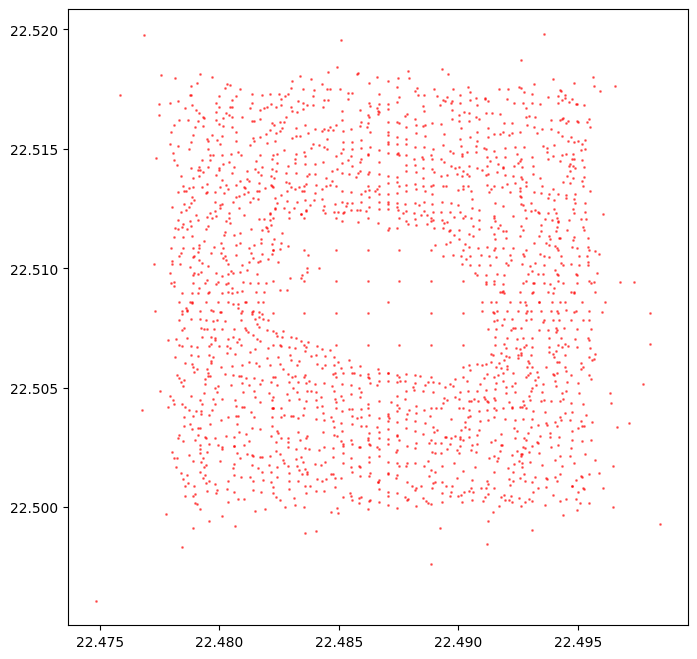

In [41]:
print(y[:10])
plot_points(y[0])

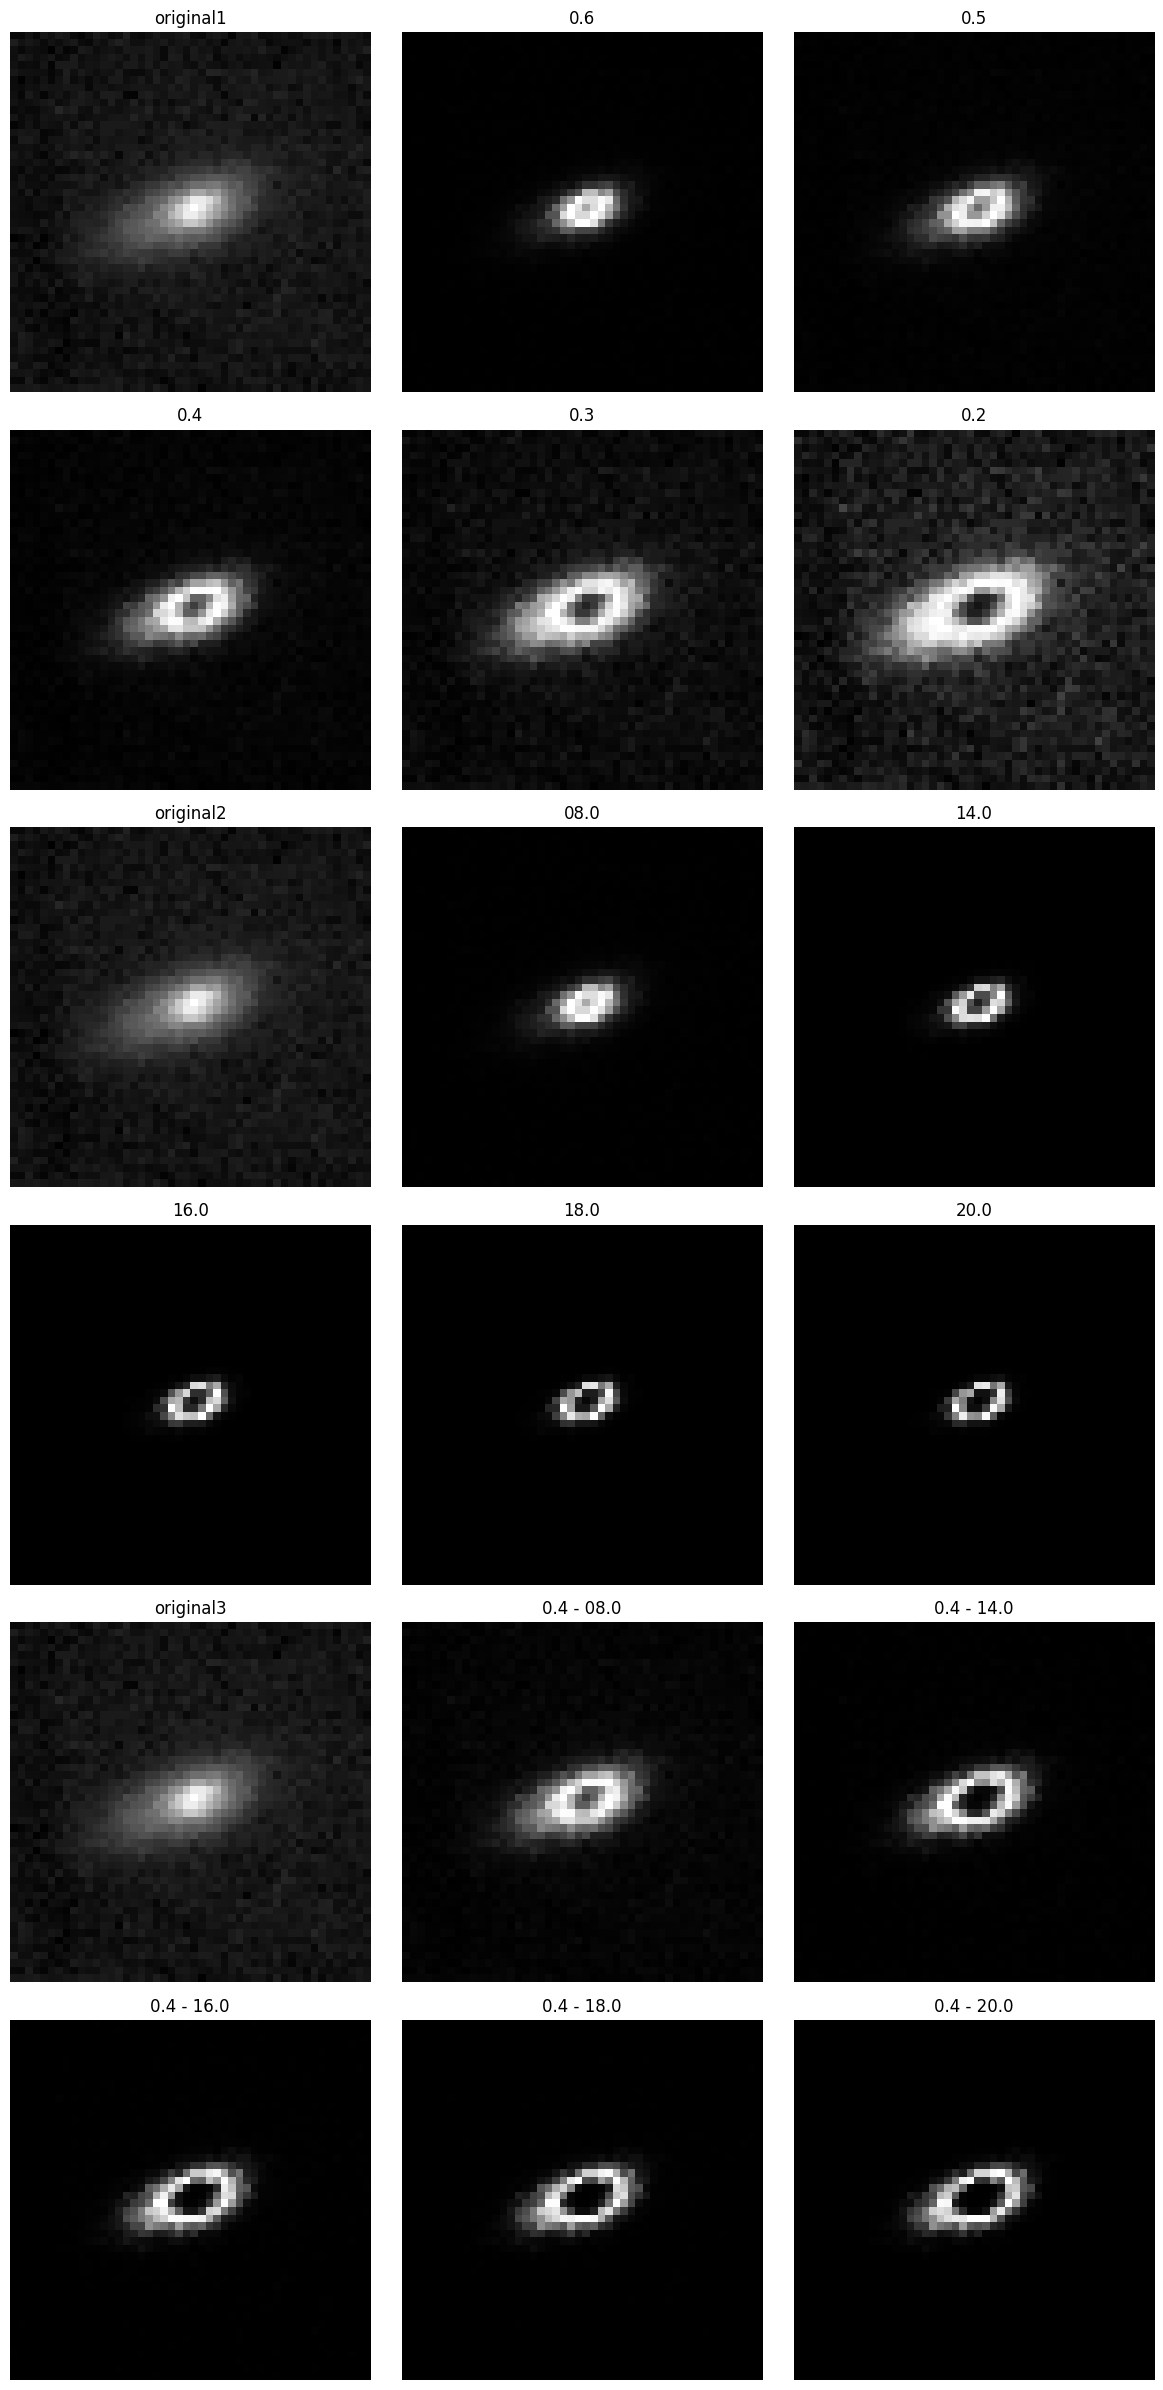

In [ ]:
def value_transform(x: torch.Tensor, 
                    peak_pos: float = 0.6, 
                    sharpness: float = 8.0) -> torch.Tensor:
    """
    Differentiable nonlinear transformation for galaxy edge processing.
    Maintains low values, amplifies mid-range, suppresses highs.
    """
    # Shift and scale input to target medium range
    scaled_x = sharpness * (x - peak_pos)
    
    # Core transformation function
    return x * torch.sigmoid(scaled_x) * (1 - torch.sigmoid(scaled_x - 2.0))

image_dict = {
    "original1": torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)),
    "0.6": value_transform(torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)), peak_pos=0.6).detach(),
    "0.5": value_transform(torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)), peak_pos=0.5).detach(),
    "0.4": value_transform(torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)), peak_pos=0.4).detach(),
    "0.3": value_transform(torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)), peak_pos=0.3).detach(),
    "0.2": value_transform(torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)), peak_pos=0.2).detach(),
    "original2": torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)),
    "08.0": value_transform(torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)), sharpness=08.0).detach(),
    "14.0": value_transform(torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)), sharpness=14.0).detach(),
    "16.0": value_transform(torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)), sharpness=16.0).detach(),
    "18.0": value_transform(torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)), sharpness=18.0).detach(),
    "20.0": value_transform(torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)), sharpness=20.0).detach(),
    "original3": torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)),
    "0.4 - 08.0": value_transform(torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)), peak_pos=0.4, sharpness=08.0).detach(),
    "0.4 - 14.0": value_transform(torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)), peak_pos=0.4, sharpness=14.0).detach(),
    "0.4 - 16.0": value_transform(torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)), peak_pos=0.4, sharpness=16.0).detach(),
    "0.4 - 18.0": value_transform(torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)), peak_pos=0.4, sharpness=18.0).detach(),
    "0.4 - 20.0": value_transform(torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)), peak_pos=0.4, sharpness=20.0).detach(),
}

plot_images(image_dict)

In [46]:
def mask_to_points_and_weights_full(mask):
    """
    Converts a masked image tensor into points with associated weights, including zero values.
    
    Parameters:
        mask (Tensor): The mask tensor representing the galaxy image after applying value_transform.
    
    Returns:
        points (Tensor): A tensor of shape (H*W, 2) containing all pixel coordinates.
        weights (Tensor): A tensor of shape (H*W,) containing the weights for all points, 
                          proportional to the brightness (zero for dark pixels).
    """
    # Get the height and width of the mask
    H, W = mask.shape
    
    # Create a grid of (x, y) coordinates for all pixels in the image
    x_coords, y_coords = torch.meshgrid(torch.arange(H), torch.arange(W))
    points = torch.stack((x_coords.flatten(), y_coords.flatten()), dim=1).float()  # Flatten to create the points tensor
    
    # The weights are the values in the mask, corresponding to each point
    weights = mask.flatten()  # Flatten the mask to create weights for all pixels
    
    return points, weights

# Example usage
# Assume `masked_image` is the tensor from value_transform
masked_image = torch.rand(100, 100)  # Example mask tensor, replace with actual mask
points, weights = mask_to_points_and_weights_full(masked_image)

print("Points:\n", points)
print("Weights:\n", weights)

def weighted_ellipse_fit_torch(points, weights):
    """
    Fit an ellipse to a set of points with associated weights using a non-iterative method in PyTorch.
    
    Parameters:
        points (Tensor): Nx2 tensor of (x, y) points.
        weights (Tensor): N-element tensor of weights corresponding to each point.
    
    Returns:
        params (Tensor): The ellipse parameters [A, B, C, D, E, F] satisfying Ax^2 + Bxy + Cy^2 + Dx + Ey + F = 0.
    """
    # Extract x and y coordinates
    x = points[:, 0]
    y = points[:, 1]
    
    # Construct the design matrix
    D = torch.stack((x**2, x*y, y**2, x, y, torch.ones_like(x)), dim=1)
    
    # Weight the design matrix
    W = torch.diag(weights)  # Create diagonal weight matrix
    D_weighted = W @ D  # Apply weights to design matrix
    
    # Solve the weighted least squares problem using SVD
    _, _, V = torch.svd(D_weighted)
    params = V[:, -1]  # Solution is the eigenvector corresponding to the smallest singular value

    # Normalize parameters for numerical stability
    params /= torch.norm(params)
    
    return params

# Example usage
points = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0], [7.0, 8.0], [9.0, 10.0]])  # Example points
weights = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])  # Higher weights favor later points

params = weighted_ellipse_fit_torch(points, weights)
print("Fitted Ellipse Parameters:", params)

Points:
 tensor([[ 0.,  0.],
        [ 0.,  1.],
        [ 0.,  2.],
        ...,
        [99., 97.],
        [99., 98.],
        [99., 99.]])
Weights:
 tensor([0.0140, 0.0453, 0.0867,  ..., 0.0484, 0.3753, 0.7882])
Fitted Ellipse Parameters: tensor([ 0.1247,  0.4528, -0.5775,  0.0408,  0.6613, -0.0838])


In [47]:
weighted_ellipse_fit_torch(*mask_to_points_and_weights_full(value_transform(torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)), peak_pos=0.6).detach()))

tensor([-4.0661e-04, -9.8546e-04, -3.2551e-04,  4.3757e-02,  3.9143e-02,
        -9.9827e-01])

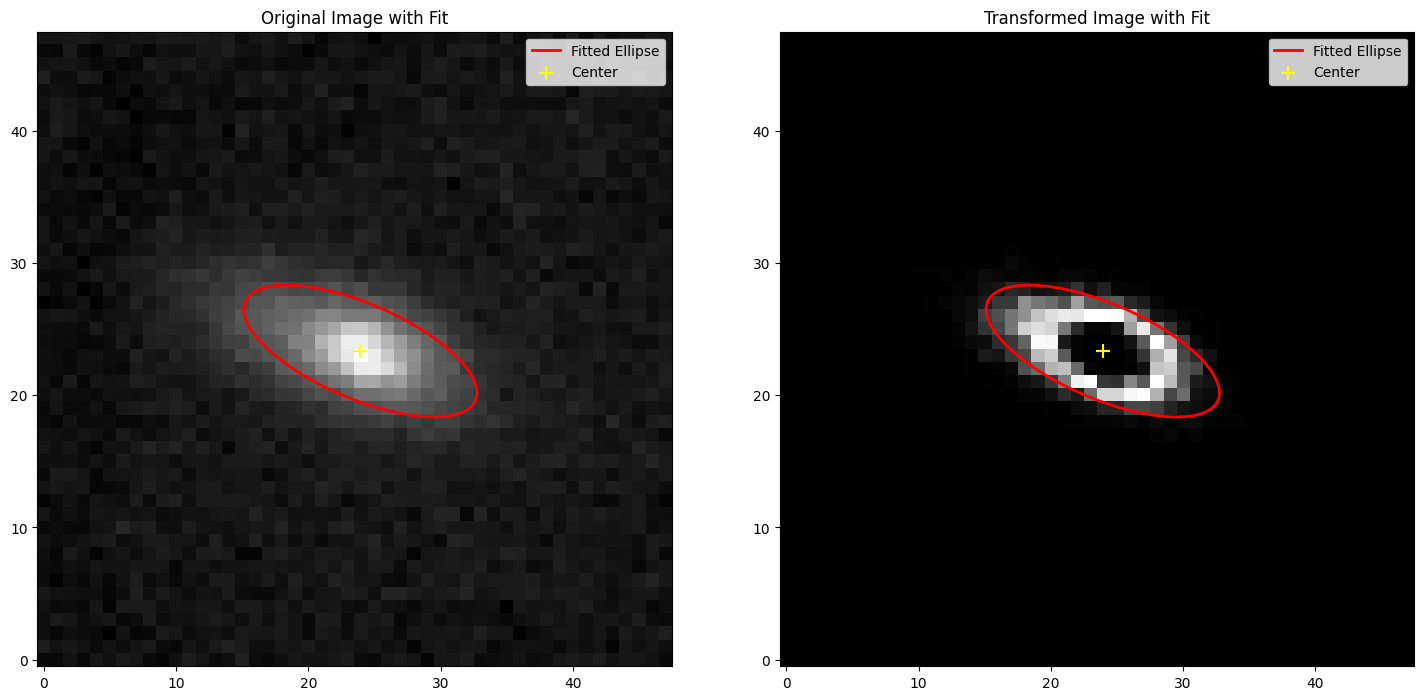

In [61]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def value_transform(x: torch.Tensor, 
                   peak_pos: float = 0.4, 
                   sharpness: float = 20.0) -> torch.Tensor:
    """
    Differentiable nonlinear transformation for galaxy edge processing.
    Maintains low values, amplifies mid-range, suppresses highs.
    """
    scaled_x = sharpness * (x - peak_pos)
    return x * torch.sigmoid(scaled_x) * (1 - torch.sigmoid(scaled_x - 2.0))

def mask_to_points_and_weights_full(mask):
    """
    Converts a masked image tensor into points with associated weights.
    """
    H, W = mask.shape
    x_coords, y_coords = torch.meshgrid(torch.arange(H), torch.arange(W))
    points = torch.stack((x_coords.flatten(), y_coords.flatten()), dim=1).float()
    weights = mask.flatten()
    return points, weights

def weighted_ellipse_fit_torch(points, weights):
    """
    Fit an ellipse to weighted points using SVD, avoiding in-place operations.
    
    Parameters:
        points (Tensor): Nx2 tensor of (x, y) points
        weights (Tensor): N-element tensor of weights
    
    Returns:
        params (Tensor): The ellipse parameters [A, B, C, D, E, F]
    """
    # Extract x and y coordinates
    x = points[:, 0]
    y = points[:, 1]
    
    # Construct the design matrix
    D = torch.stack((x**2, x*y, y**2, x, y, torch.ones_like(x)), dim=1)
    
    # Create diagonal weight matrix and apply weights
    W = torch.diag_embed(weights)
    D_weighted = torch.matmul(W, D)
    
    # Solve using SVD
    U, S, V = torch.svd(D_weighted)
    params = V[:, -1]
    
    # Normalize parameters WITHOUT in-place operation
    norm = torch.norm(params)
    params = params / (norm + 1e-8)  # Add small epsilon for numerical stability
    
    return params

def plot_galaxy_ellipse(image: torch.Tensor, params: torch.Tensor, ax=None):
    """
    Plot the galaxy image with fitted ellipse overlay.
    
    Parameters:
        image (torch.Tensor): Original galaxy image
        params (torch.Tensor): Fitted ellipse parameters [A, B, C, D, E, F]
        ax (matplotlib.axes.Axes, optional): The axes to plot on
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the galaxy image
    ax.imshow(image.cpu().numpy(), cmap='gray', origin='lower')
    
    # Convert parameters to tensors
    A, B, C, D, E, F = [torch.tensor(x) for x in params.tolist()]
    
    # Calculate ellipse center
    denominator = 4*A*C - B**2
    cx = (B*E - 2*C*D) / denominator
    cy = (B*D - 2*A*E) / denominator
    
    # Calculate rotation angle and semi-axes
    theta = 0.5 * torch.atan2(B, A - C)
    cos_t = torch.cos(theta)
    sin_t = torch.sin(theta)
    
    # Calculate semi-axes lengths
    a_squared = -2 * (A*cx**2 + C*cy**2 + B*cx*cy + D*cx + E*cy + F) / \
                (A*cos_t**2 + B*cos_t*sin_t + C*sin_t**2)
    b_squared = -2 * (A*cx**2 + C*cy**2 + B*cx*cy + D*cx + E*cy + F) / \
                (A*sin_t**2 - B*cos_t*sin_t + C*cos_t**2)
    
    a = torch.sqrt(torch.abs(a_squared))
    b = torch.sqrt(torch.abs(b_squared))
    
    # Generate ellipse points
    t = torch.linspace(0, 2*np.pi, 200)
    x_circle = a * torch.cos(t)
    y_circle = b * torch.sin(t)
    
    # Rotate and translate
    R = torch.tensor([[cos_t, -sin_t],
                     [sin_t, cos_t]])
    points = torch.stack([x_circle, y_circle])
    rotated_points = R @ points
    x = rotated_points[0] + cx
    y = rotated_points[1] + cy
    
    # Plot ellipse overlay
    ax.plot(y.numpy(), x.numpy(), 'r-', label='Fitted Ellipse', linewidth=2)
    ax.scatter(cy.item(), cx.item(), color='yellow', marker='+', s=100, label='Center')
    
    # Customize plot
    ax.set_title('Galaxy Image with Fitted Ellipse')
    ax.legend()
    return ax

def process_and_fit_galaxy(image: torch.Tensor):
    """
    Complete pipeline for processing a galaxy image and fitting an ellipse.
    
    Parameters:
        image (torch.Tensor): Input galaxy image tensor
        
    Returns:
        params (torch.Tensor): Fitted ellipse parameters
        fig (matplotlib.figure.Figure): Figure with the result
    """
    # Apply value transform to enhance edges
    transformed = value_transform(image)
    
    # Convert to points and weights
    points, weights = mask_to_points_and_weights_full(transformed)
    
    # Fit ellipse
    params = weighted_ellipse_fit_torch(points, weights)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Original image with fit
    plot_galaxy_ellipse(image, params, ax1)
    ax1.set_title('Original Image with Fit')
    
    # Transformed image with fit
    plot_galaxy_ellipse(transformed, params, ax2)
    ax2.set_title('Transformed Image with Fit')
    
    plt.tight_layout()
    return params, fig

galaxy_image = torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device))

# Example usage:
# Assuming 'galaxy_image' is your input tensor:
params, fig = process_and_fit_galaxy(galaxy_image)
plt.show()

In [64]:
x = galaxy_image
x.requires_grad_(True)
y = weighted_ellipse_fit_torch(*mask_to_points_and_weights_full(value_transform(x)))  # Differentiable operation
print(y)
y.sum().backward()  # Should work if differentiable

print(x.grad.shape)
print(x.grad)  # Should be non-None if differentiable

tensor([-8.9112e-04, -6.3751e-04, -2.8441e-04,  5.6861e-02,  2.8493e-02,
        -9.9797e-01], grad_fn=<DivBackward0>)
torch.Size([48, 48])
tensor([[ 2.0156e-09, -3.3836e-08, -9.5646e-07,  ..., -1.6189e-05,
         -6.7831e-06, -9.5720e-07],
        [ 1.0541e-05,  4.3461e-07, -1.0073e-07,  ..., -3.6347e-06,
         -9.1423e-06, -2.8154e-06],
        [ 8.0183e-07,  8.1934e-08,  3.5257e-07,  ..., -4.7113e-06,
         -1.0245e-05, -9.2609e-05],
        ...,
        [-6.5031e-06, -8.4870e-06, -1.3787e-05,  ..., -2.0270e-06,
         -4.6486e-06, -4.7326e-06],
        [-5.3855e-07, -4.5063e-07, -6.1165e-05,  ..., -3.5910e-05,
         -8.5062e-05, -2.2815e-05],
        [-2.2132e-05, -1.9552e-05, -2.8611e-05,  ..., -1.2456e-05,
         -6.1337e-05, -3.1899e-05]])


In [73]:
def sample_topk_diff(tensor: torch.Tensor, 
                    k: int, 
                    tau: float = 1.0, 
                    hard: bool = False) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Fully differentiable sampling from the top-k values of a tensor with coordinate output.

    Args:
        tensor (torch.Tensor): Input tensor (B, H, W) or (H, W)
        k (int): Number of top values to consider
        tau (float): Temperature for Gumbel-Softmax
        hard (bool): If True, use hard sampling (one-hot)

    Returns:
        tuple[torch.Tensor, torch.Tensor]: (coordinates, probabilities)
            - coordinates: tensor of shape (B, k, 2) or (k, 2) containing (y, x) coordinates
            - probabilities: tensor of shape (B, k) or (k) containing sampling probabilities
    """
    # Add batch dimension if needed
    if len(tensor.shape) == 2:
        tensor = tensor.unsqueeze(0)
    
    B, H, W = tensor.shape
    
    # Create coordinate grid
    y_grid, x_grid = torch.meshgrid(
        torch.arange(H, dtype=tensor.dtype, device=tensor.device),
        torch.arange(W, dtype=tensor.dtype, device=tensor.device),
        indexing='ij'
    )
    
    # Flatten all tensors
    flattened = tensor.reshape(B, -1)  # B x (H*W)
    y_flat = y_grid.reshape(-1).repeat(B, 1)  # B x (H*W)
    x_flat = x_grid.reshape(-1).repeat(B, 1)  # B x (H*W)
    
    # Get the top-k values and their indices
    topk_values, topk_indices = torch.topk(flattened, k, dim=-1)  # B x k
    
    # Apply Gumbel-Softmax to the top-k values
    gumbel_noise = -torch.log(-torch.log(torch.rand_like(topk_values)))
    y = topk_values + gumbel_noise
    probs = F.softmax(y / tau, dim=-1)  # B x k
    
    if hard:
        # Use hard sampling (one-hot)
        y_hard = torch.zeros_like(probs)
        y_hard.scatter_(-1, torch.argmax(probs, dim=-1, keepdim=True), 1.0)
        probs = (y_hard - probs).detach() + probs
    
    # Gather the coordinates using the indices
    y_coords = torch.gather(y_flat, 1, topk_indices)  # B x k
    x_coords = torch.gather(x_flat, 1, topk_indices)  # B x k
    
    # Stack coordinates into (B, k, 2) tensor
    coords = torch.stack([y_coords, x_coords], dim=-1)  # B x k x 2
    
    # Remove batch dimension if input was 2D
    if len(tensor.shape) == 3 and tensor.shape[0] == 1:
        coords = coords.squeeze(0)  # k x 2
        probs = probs.squeeze(0)    # k
    
    return coords, probs

coords, probs = sample_topk_diff(value_transform(torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)), sharpness=20.0), 30)

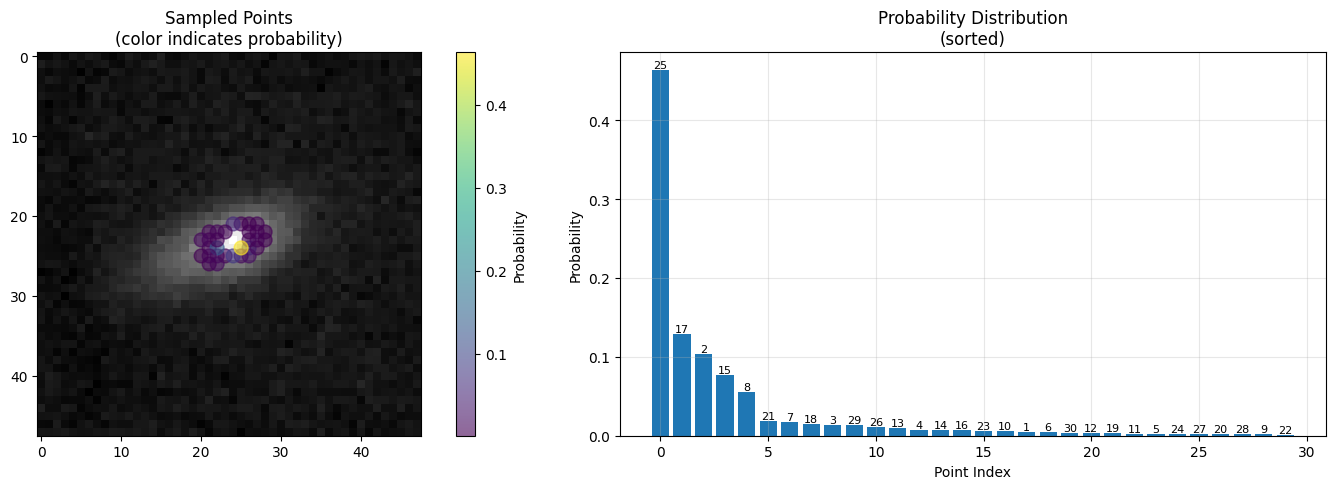

In [77]:
def visualize_sampling(image: torch.Tensor, coords: torch.Tensor, probs: torch.Tensor, 
                      show_probabilities: bool = True, figsize: tuple = (15, 5)):
    """
    Visualize the sampled points and their probabilities on the image.
    
    Args:
        image: torch.Tensor of shape (H, W) - the transformed image
        coords: torch.Tensor of shape (k, 2) - the y,x coordinates
        probs: torch.Tensor of shape (k) - the sampling probabilities
        show_probabilities: bool - whether to show probability distribution
        figsize: tuple - figure size
    """
    # Convert tensors to numpy for plotting
    image_np = image.detach().cpu().numpy()
    coords_np = coords.detach().cpu().numpy()
    probs_np = probs.detach().cpu().numpy()
    
    if show_probabilities:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(figsize[0]//2, figsize[1]))
    
    # Plot the image and points
    im = ax1.imshow(image_np, cmap='gray')
    scatter = ax1.scatter(coords_np[:, 1], coords_np[:, 0], 
                         c=probs_np, cmap='viridis', 
                         s=100, alpha=0.6)
    ax1.set_title('Sampled Points\n(color indicates probability)')
    plt.colorbar(scatter, ax=ax1, label='Probability')
    
    # # Add coordinate labels to points
    # for i, (y, x) in enumerate(coords_np):
    #     ax1.annotate(f'{i+1}', (x, y), 
    #                 xytext=(5, 5), textcoords='offset points',
    #                 color='white', fontsize=8,
    #                 bbox=dict(facecolor='black', alpha=0.7, pad=0.5))
    
    if show_probabilities:
        # Plot probability distribution
        sorted_probs, sort_idx = torch.sort(probs, descending=True)
        sorted_probs_np = sorted_probs.detach().cpu().numpy()
        
        ax2.bar(np.arange(len(probs_np)), sorted_probs_np)
        ax2.set_title('Probability Distribution\n(sorted)')
        ax2.set_xlabel('Point Index')
        ax2.set_ylabel('Probability')
        ax2.grid(True, alpha=0.3)
        
        # Add point indices to bars
        for i, prob in enumerate(sorted_probs_np):
            point_idx = sort_idx[i].item() + 1
            ax2.text(i, prob, f'{point_idx}', 
                    ha='center', va='bottom',
                    fontsize=8)
    
    plt.tight_layout()
    plt.show()

visualize_sampling(torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)), coords, probs)

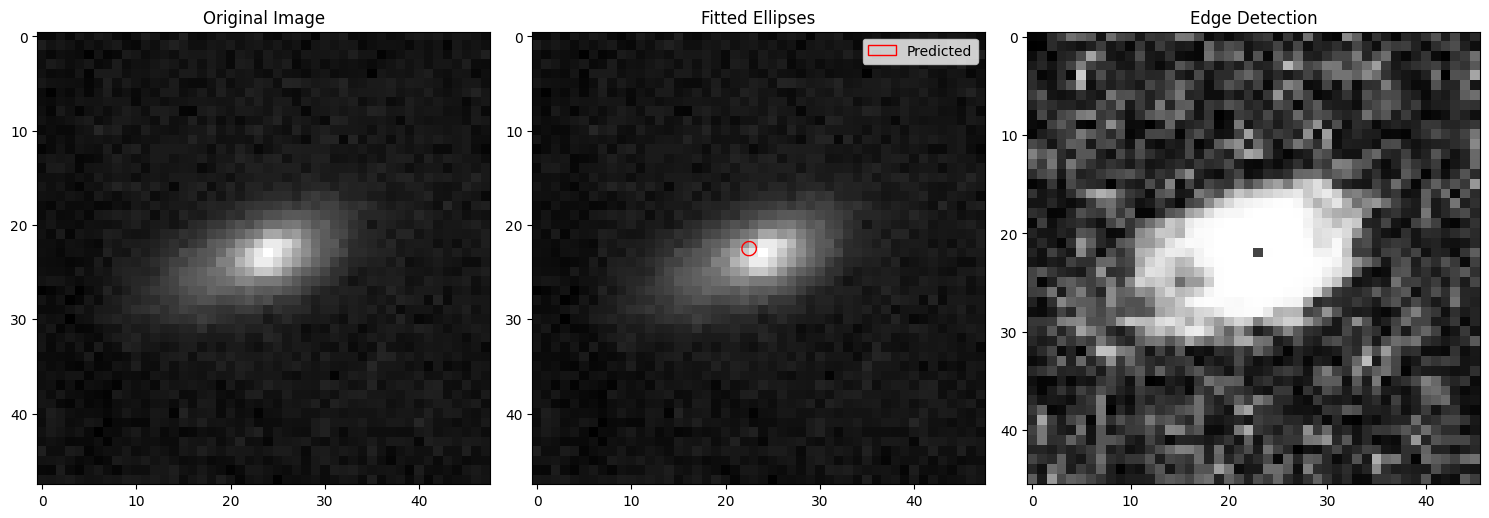

Predicted ellipse:
  Center: [22.486856 22.508797]
  Major axis: 1.5402750968933105
  Minor axis: 1.5011769533157349
  Angle (deg): 157.40623118803722


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import torch

# Suppose x is the input image tensor (with grad) and image is a numpy or PIL image for display.
# Get predicted ellipse from our differentiable model:
# fit_ellipse returns: center (2,), axes (tuple: major_axis, minor_axis), angle (radians)
pred_center, pred_axes, pred_angle = fit_ellipse(mask_to_points(rgb_to_edges(x, edge_sensitivity=0.3)))
# Convert predicted outputs to NumPy arrays for plotting
pred_center_np = pred_center.detach().cpu().numpy()
# We assume our fit_ellipse returns full axis lengths; if in your usage you need half–lengths multiply by 0.5.
pred_major = pred_axes[0].detach().cpu().numpy()
pred_minor = pred_axes[1].detach().cpu().numpy()
pred_angle_deg = pred_angle.detach().cpu().item() * 180 / 3.14159265  # convert to degrees

# Create figure with subplots for visualization
plt.figure(figsize=(15, 5))

# Subplot 1: Display the original image
plt.subplot(131)
plt.imshow(torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)), cmap='gray')
plt.title('Original Image')

# Subplot 2: Display the image with both ellipse fits
plt.subplot(132)
plt.imshow(torch.einsum('chw,c->hw', image_tensor.detach(), torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device)), cmap='gray')
plt.title('Fitted Ellipses')

# Plot the predicted ellipse (using red outline).
# (Use pred_center_np for center and pred_major, pred_minor for widths.
#  If your fit_ellipse returns full lengths and you prefer the Matplotlib Ellipse constructor
#  to be provided with full width/height, then you can use them directly.)
predicted_ellipse = Ellipse(
    xy=pred_center_np,
    width=pred_major,
    height=pred_minor,
    angle=pred_angle_deg,
    facecolor='none',
    edgecolor='red',
    label='Predicted'
)
plt.gca().add_patch(predicted_ellipse)

# # Plot the OpenCV ellipse (if available) in blue.
# if opencv_result is not None:
#     (cv_center, cv_axes, cv_angle) = opencv_result  # cv_axes: (width, height)
#     opencv_ellipse = Ellipse(
#         xy=cv_center,
#         width=cv_axes[0],
#         height=cv_axes[1],
#         angle=cv_angle,
#         facecolor='none',
#         edgecolor='blue',
#         label='OpenCV'
#     )
#     plt.gca().add_patch(opencv_ellipse)

plt.legend()

# Subplot 3: Display the edge detection result
plt.subplot(133)
edge_mask = rgb_to_edges(image_tensor)  # image_tensor assumed to be the torch tensor version
plt.imshow(edge_mask.detach().cpu().numpy(), cmap='gray')
plt.title('Edge Detection')

plt.tight_layout()
plt.show()

# Finally, print out the numerical results
print(f"Predicted ellipse:")
print(f"  Center: {pred_center_np}")
print(f"  Major axis: {pred_major}")
print(f"  Minor axis: {pred_minor}")
print(f"  Angle (deg): {pred_angle_deg}")

# if opencv_result is not None:
#     (cv_center, cv_axes, cv_angle) = opencv_result
#     print(f"\nOpenCV ellipse:")
#     print(f"  Center: {cv_center}")
#     print(f"  Major axis (width/2): {cv_axes[0]/2}")
#     print(f"  Minor axis (height/2): {cv_axes[1]/2}")
#     print(f"  Angle (deg): {cv_angle}")

In [ ]:
x = image_tensor
y = fit_ellipse(mask_to_points(rgb_to_edges(x, edge_sensitivity=0.3)))  # Differentiable operation
print(y)
y.sum().backward()  # Should work if differentiable

print(x.grad)  # Should be non-None if differentiable

(tensor([22.4869, 22.5088], grad_fn=<MeanBackward1>), (tensor(0.0112, grad_fn=<MulBackward0>), tensor(0.0109, grad_fn=<MulBackward0>)), tensor(2.7473, grad_fn=<Atan2Backward0>))


AttributeError: 'tuple' object has no attribute 'sum'

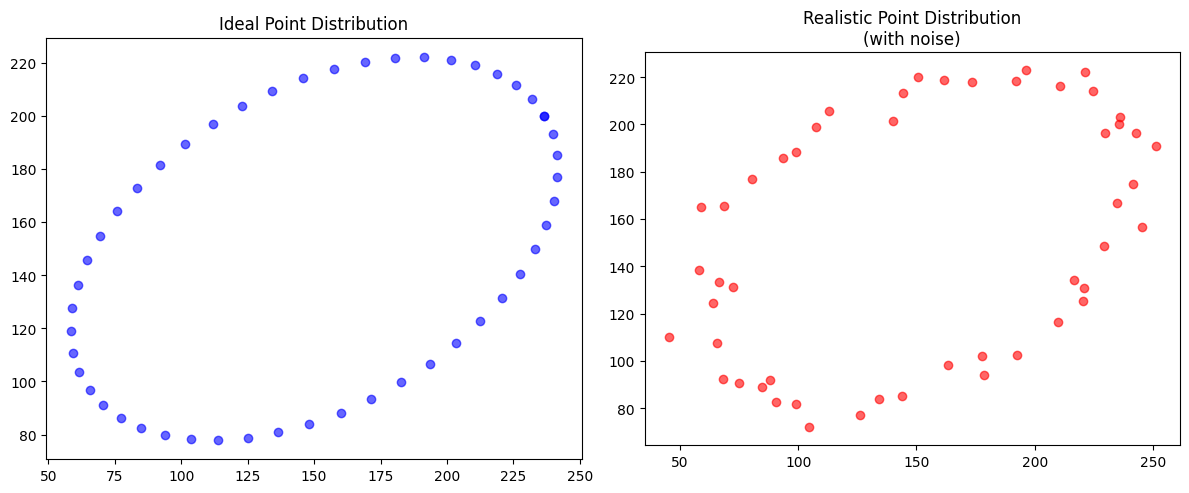

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate ideal points along an ellipse
def generate_ideal_points(n_points=50, a=100, b=60, angle=30, center=(150, 150), noise=0):
    # Generate angles
    t = np.linspace(0, 2*np.pi, n_points)
    
    # Generate perfect ellipse points
    x = a * np.cos(t)
    y = b * np.sin(t)
    
    # Rotate points
    angle_rad = np.deg2rad(angle)
    x_rot = x * np.cos(angle_rad) - y * np.sin(angle_rad)
    y_rot = x * np.sin(angle_rad) + y * np.cos(angle_rad)
    
    # Add center offset and optional noise
    points = np.column_stack([
        x_rot + center[0] + np.random.normal(0, noise, n_points),
        y_rot + center[1] + np.random.normal(0, noise, n_points)
    ])
    
    return points

# Create figure comparing ideal vs noisy points
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ideal points
ideal_points = generate_ideal_points(n_points=50, noise=0)
ax1.scatter(ideal_points[:, 0], ideal_points[:, 1], c='blue', alpha=0.6)
ax1.set_title('Ideal Point Distribution')
ax1.set_aspect('equal')

# Plot noisy points
noisy_points = generate_ideal_points(n_points=50, noise=5)
ax2.scatter(noisy_points[:, 0], noisy_points[:, 1], c='red', alpha=0.6)
ax2.set_title('Realistic Point Distribution\n(with noise)')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()
